# Do you recommend this book?

# By Gal Halili

# Data sources:

The data was clawed from Storytel site.

Sources of information that I used in the project:

-Chat gpt

-Campus il

-Selenium website
 
-seaborn website

-w3schools

-pandas website

-geeksforgeeks

-machinelearningplus

# Liabraries

In [1]:
import pandas as pd 
import csv
import requests
from bs4 import BeautifulSoup
import re

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

from selenium import webdriver
from selenium.webdriver.common.by import By
import time
import datetime
from dateutil.parser import parse

# Get the url of any book genre
We will use BeautifulSoup to crawl the links from the site's main page

In [67]:
def get_genres_urls(home_url): 
    
    genres_links = []
    base_link = "https://www.storytel.com"
    
    response_genre = requests.get(home_url)
    soup_genre= BeautifulSoup(response_genre.content, "html.parser")  
    
    s_g = soup_genre.select('.topnavigation-component')
    
    for s in s_g:
        for i in range(5,23):
            g = s.find_all("a", {'class':"item-link svelte-1jsaki7"})[i].get("href")
            genres_links.append(base_link+g)

    return genres_links

In [68]:
genres_links = get_genres_urls("https://www.storytel.com")
genres_links

['https://www.storytel.com/il/he/categories/1-',
 'https://www.storytel.com/il/he/categories/2-',
 'https://www.storytel.com/il/he/categories/3-',
 'https://www.storytel.com/il/he/categories/4-',
 'https://www.storytel.com/il/he/categories/5-',
 'https://www.storytel.com/il/he/categories/6-',
 'https://www.storytel.com/il/he/categories/7-',
 'https://www.storytel.com/il/he/categories/8-',
 'https://www.storytel.com/il/he/categories/9-',
 'https://www.storytel.com/il/he/categories/10-',
 'https://www.storytel.com/il/he/categories/11-',
 'https://www.storytel.com/il/he/categories/12-',
 'https://www.storytel.com/il/he/categories/13-',
 'https://www.storytel.com/il/he/categories/14-',
 'https://www.storytel.com/il/he/categories/15-',
 'https://www.storytel.com/il/he/categories/16-',
 'https://www.storytel.com/il/he/categories/20-',
 'https://www.storytel.com/il/he/categories/21-']

# Get the books urls
In this section we have two functions:

1)An auxiliary function that crawls a link of a certain book genre and returns the links to the books that appear on this page

2)The main function that scrolls down all of the genrs pages with Selenium

In [69]:
def scrape(soup_genre, link_list, name_list):
    s_g = soup_genre.select('.gridBookTitle')

    for s in s_g:
        g = s.find_all("a", {'class':"handled-js"})[0].get("href")
        link_list.append('https://www.storytel.com' + g)

        book_name = s.find_all("a", {'class':"handled-js"})[0].text.strip()
        name_list.append(book_name)
        
    return [link_list, name_list]    

In [70]:
def get_books_links(genres_links):

    books_links = []
    books_names = []
    base_link = 'https://www.storytel.com'

    # Set up Selenium webdriver
    driver = webdriver.Chrome()  # Replace with the appropriate WebDriver for your browser

    # Load the website
    for gen_link in genres_links:
        driver.get(gen_link)

        # Scroll the web page
        scroll_pause_time = 2  # Adjust the pause time between scrolls as needed
        scroll_height = driver.execute_script("return document.documentElement.scrollHeight")

        # Specify the number of pages to scroll
        num_pages = 10
        pages_scrolled = 0

        while pages_scrolled < num_pages:
            # Scroll to the bottom of the page
            driver.execute_script("window.scrollTo(0, document.documentElement.scrollHeight);")

            # Wait for the page to load new content
            time.sleep(scroll_pause_time)

            # Calculate the new scroll height after scrolling
            new_scroll_height = driver.execute_script("return document.documentElement.scrollHeight")

            # Check if the scroll position has reached the end of the page
            if new_scroll_height == scroll_height:
                break

            # Update the scroll height_
            scroll_height = new_scroll_height
            pages_scrolled += 1

        # Extract book URLs
        soup = BeautifulSoup(driver.page_source, "html.parser")
        res = scrape(soup , books_links, books_names)

    # Close the browser
    driver.quit()
    return [books_links,books_names]

In [72]:
res = get_books_links(genres_links)
books_links = res[0]
books_names = res[1]

# Saving the books links
We are saving the link in a dataframe and convert to csv

In [88]:
links_df = pd.DataFrame({"link":books_links, "book_name":books_names})
books_links_csv = links_df.to_csv('books_links_df.csv',index = False, encoding='utf-8')

In [89]:
books_links_df = pd.read_csv("books_links_df.csv")
books_links_df

,link,book_name
0,https://www.storytel.com/il/he/books/%D7%94%D7...,הכינה נחמה
1,https://www.storytel.com/il/he/books/%D7%90%D7...,אבא עושה בושות
2,https://www.storytel.com/il/he/books/harry-pot...,Harry Potter and the Prisoner of Azkaban
3,https://www.storytel.com/il/he/books/harry-pot...,Harry Potter and the Philosopher's Stone
4,https://www.storytel.com/il/he/books/%D7%A7%D7...,קרמר החתול ישן כל הזמן
...,...,...
17645,https://www.storytel.com/il/he/books/tell-the-...,Tell The Devil You Are About To Make A Comeback
17646,https://www.storytel.com/il/he/books/eyes-wide...,Eyes Wide Open
17647,https://www.storytel.com/il/he/books/now-is-th...,Now Is The Time
17648,https://www.storytel.com/il/he/books/the-lords...,The Lord's Prayer


# get_books_details function
This function crawls the links we provided in the previous section and extracts all the relevant data on each book.

The function returns a dataframe with all the collected information.

In [90]:
def get_books_details(books_links):
    books_names = []
    author_names = []
    books_types = []
    summarys = []
    book_genre = []
    posting_dates = []
    publishing_companys = []
    original_names = []
    translators = []
    publishing_years =[]
    genres = []
    stars = []
    books_language = []
    release_dates = []
    announcers_names =[]
    recordings_length = []
    book_num = 1
    for link in books_links:
        book_response = requests.get(link)
        book_soup = BeautifulSoup(book_response.content, "html.parser")  

        s_i = book_soup.select('.bookdetails-component')

        for s in s_i:
            try:name = s.find("h1", class_="title svelte-1rjicxl").text.strip()
            except:books_names.append("NaN")
            else:books_names.append(name)
           
            try:author = s.select('a')[0].text.strip()
            except:author_names.append("NaN")
            else:author_names.append(author)
                
            try:publishing_company = s.find_all("a", {'data-collectid':"book-description-publisher"})[0].text.strip()
            except:publishing_companys.append("NaN")
            else:publishing_companys.append(publishing_company)

            try:genre = s.find_all("a", {'data-collectid':"book-info-category"})[0].text.strip()
            except:genres.append("NaN")
            else:genres.append(genre)

            try:star = s.find_all("dd", {'class':"info-def svelte-t5p087"})[0].text.strip()
            except:stars.append("NaN")
            else:stars.append(star)

            if (s.find_all("dd", {'class':"info-def svelte-t5p087"})[1].text.strip().find("חלק") == -1): 
                flag2 = -1
                try:language = s.find_all("dd", {'class':"info-def svelte-t5p087"})[1].text.strip() 
                except:books_language.append("NaN")
                else:books_language.append(language)
            else:
                flag2 = 1
                try:language = s.find_all("dd", {'class':"info-def svelte-t5p087"})[2].text.strip() 
                except:books_language.append("NaN")
                else:books_language.append(language)
                    

            try:release_date = s.find_all("div", {'class':"release-date svelte-1rjicxl"})[0].text.strip()
            except:release_dates.append("NaN")
            else:release_dates.append(release_date)  

                
            flag1 = release_date.find("ספר מוקלט")
            if flag1 == -1:# The book is digital
                
                try:book_type = s.find_all('span', {'class': 'info-item svelte-idzcln'})[1].text.strip()
                except:books_types.append("NaN") 
                else:books_types.append(book_type)    
                
                try:publishing_year = re.search(r'\d{4}', s.find_all('span', {'class': 'info-item svelte-idzcln' })[2].text.strip()).group(0)
                except:publishing_years.append("NaN")
                else:publishing_years.append(publishing_year)
                    
                announcers_names.append("NaN")    
                recordings_length.append("NaN")
                    
            else: # The book is audio
                book_type = s.find_all('span', {'class': 'info-item svelte-idzcln' })[2].text.strip()
                books_types.append(book_type)
            
                try:year = re.search(r'\d{4}', s.find_all('span', {'class': 'info-item svelte-idzcln'})[3].text.strip()).group(0)
                except:publishing_years.append("NaN")
                else:publishing_years.append(year)
            
                announcer = s.find_all('span', {'class': 'info-item svelte-idzcln'})[1].text.strip()
                announcers_names.append(announcer)
                
                
                if flag2 == -1:
                    try:recording_length = s.find_all("dd", {'class':"info-def svelte-t5p087"})[3].text.strip()
                    except:recordings_length.append("NaN")
                    else:recordings_length.append(recording_length)
                else:
                    try:recording_length = s.find_all("dd", {'class':"info-def svelte-t5p087"})[4].text.strip()
                    except:recordings_length.append("NaN")
                    else:recordings_length.append(recording_length)
              
                print(book_num)
                book_num += 1

    books_df=pd.DataFrame({"book_name": books_names, "author_name":author_names, "announcer_name":announcers_names, "book_type":books_types, "publishing":publishing_companys, "publishing_year":publishing_years, "genre":genres, "stars":stars, "language":books_language, "release_date":release_dates, "recording_length":recordings_length}) 
    return books_df   
   

# The actual crawling
In this part we will use the function above and extract the information about all 5000 books separately and also save them in different dataframes and csv files.

In [92]:
books_df1=get_books_details(books_links_df[0:5001]["link"])
books_df_csv1 = books_df1.to_csv('books_df1.csv',index = False, encoding='utf-8')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


In [93]:
books_df1 = pd.read_csv("books_df1.csv")
books_df1

,book_name,author_name,announcer_name,book_type,publishing,publishing_year,genre,stars,language,release_date,recording_length
0,הכינה נחמה,מאיר שלו,קריינות: מאיר שלו,ספר מוקלט,Storyside,2021.0,ילדים,4.56,עברית,תאריך פרסום\nספר מוקלט: 27 באפריל 2021,10דקות
1,אבא עושה בושות,מאיר שלו,קריינות: מאיר שלו,ספר מוקלט,Storyside,2021.0,ילדים,4.29,עברית,תאריך פרסום\nספר מוקלט: 27 באפריל 2021,6דקות
2,Harry Potter and the Prisoner of Azkaban,J.K. Rowling,קריינות: Stephen Fry,ספר מוקלט בנוסף ספר דיגיטלי,Pottermore,2015.0,ילדים,4.82,אנגלית,תאריך פרסום\nספר מוקלט: 20 בנובמבר 2015\nספר ד...,12שעות 3דקות
3,Harry Potter and the Philosopher's Stone,J.K. Rowling,קריינות: Stephen Fry,ספר מוקלט בנוסף ספר דיגיטלי,Pottermore,2015.0,ילדים,4.70,אנגלית,תאריך פרסום\nספר מוקלט: 20 בנובמבר 2015\nספר ד...,8שעות 25דקות
4,קרמר החתול ישן כל הזמן,מאיר שלו,קריינות: איל קיציס,ספר מוקלט,Storyside,2021.0,ילדים,4.46,עברית,תאריך פרסום\nספר מוקלט: 27 באפריל 2021,3דקות
...,...,...,...,...,...,...,...,...,...,...,...
4993,THE DOG TRAINER'S RESOURCE 2,אני רוצה לנסות!,NaN,ספר דיגיטלי,Dogwise Publishing,2008.0,עיון,0.00,אנגלית,תאריך פרסום\nספר דיגיטלי: 1 בינואר 2008,NaN
4994,Positive Training For Show Dogs,Vicki Ronchette,NaN,ספר דיגיטלי,Dogwise Publishing,2007.0,עיון,0.00,אנגלית,תאריך פרסום\nספר דיגיטלי: 1 בינואר 2007,NaN
4995,THE DOG TRAINER'S RESOURCE,אני רוצה לנסות!,NaN,ספר דיגיטלי,Dogwise Publishing,2006.0,עיון,0.00,אנגלית,תאריך פרסום\nספר דיגיטלי: 1 בינואר 2006,NaN
4996,"The Dog Aggression Workbook, 3rd Edition",James O'Heare,NaN,ספר דיגיטלי,BehaveTech Publishing,2004.0,עיון,0.00,אנגלית,תאריך פרסום\nספר דיגיטלי: 1 בינואר 2004,NaN


In [104]:
books_df2=get_books_details(books_links_df[5001:10001]["link"])
books_df_csv2 = books_df2.to_csv('books_df2.csv',index = False, encoding='utf-8')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054


In [105]:
books_df2 = pd.read_csv("books_df2.csv")
books_df2

,book_name,author_name,announcer_name,book_type,publishing,publishing_year,genre,stars,language,release_date,recording_length
0,You Be The Judge - The Collie,Robert Cole,NaN,ספר דיגיטלי,Dogwise Publishing,2002.0,עיון,0.00,אנגלית,תאריך פרסום\nספר דיגיטלי: 1 בינואר 2002,NaN
1,You Be The Judge - The Brussels Griffon,Robert Cole,NaN,ספר דיגיטלי,Dogwise Publishing,2002.0,עיון,0.00,אנגלית,תאריך פרסום\nספר דיגיטלי: 1 בינואר 2002,NaN
2,The Art Of Introducing Dogs,Louise Ginman,NaN,ספר דיגיטלי,Balboa Press,2013.0,עיון,0.00,אנגלית,תאריך פרסום\nספר דיגיטלי: 1 בינואר 2013,NaN
3,Visiting The Dog Park,Cheryl Smith,NaN,ספר דיגיטלי,Dogwise Publishing,2007.0,עיון,0.00,אנגלית,תאריך פרסום\nספר דיגיטלי: 1 בינואר 2007,NaN
4,Schutzhund Obedience,Sheila Booth,NaN,ספר דיגיטלי,Podium Publications,1992.0,עיון,0.00,אנגלית,תאריך פרסום\nספר דיגיטלי: 1 בינואר 1992,NaN
...,...,...,...,...,...,...,...,...,...,...,...
4996,La estrella sobre el bosque,Stefan Zweig,קריינות: José Luis Espina,ספר מוקלט,SAGA Egmont,2020.0,סיפורים קצרים,4.31,ספרדית,תאריך פרסום\nספר מוקלט: 29 באוקטובר 2020,25דקות
4997,Opowieść więzienna,K.S. Rutkowski,קריינות: Leszek Filipowicz,ספר מוקלט בנוסף ספר דיגיטלי,SAGA Egmont,2020.0,סיפורים קצרים,3.83,פולנית,תאריך פרסום\nספר מוקלט: 26 באוקטובר 2020\nספר ...,28דקות
4998,The Dancing Girl of Ganymede,Leigh Brackett,NaN,ספר דיגיטלי,Positronic Publishing,2020.0,סיפורים קצרים,0.00,אנגלית,תאריך פרסום\nספר דיגיטלי: 26 בספטמבר 2020,NaN
4999,The Parenticide Club,Ambrose Bierce,קריינות: Peter Yearsley,ספר מוקלט בנוסף ספר דיגיטלי,SAGA Egmont,2020.0,סיפורים קצרים,0.00,אנגלית,תאריך פרסום\nספר מוקלט: 2 בנובמבר 2020\nספר די...,48דקות


In [110]:
books_df3=get_books_details(books_links_df[10001:17651]["link"])
books_df_csv3 = books_df3.to_csv('books_df3.csv',index = False, encoding='utf-8')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699


In [111]:
books_df3 = pd.read_csv("books_df3.csv")
books_df3

,book_name,author_name,announcer_name,book_type,publishing,publishing_year,genre,stars,language,release_date,recording_length
0,The Time Machine,H.G. Wells,NaN,ספר דיגיטלי,Mint Editions,2020.0,סיפורים קצרים,4.50,אנגלית,תאריך פרסום\nספר דיגיטלי: 23 ביוני 2020,NaN
1,La Dama del Perrito,Antón Chéjov,קריינות: Benjamín Figueres,ספר מוקלט,SAGA Egmont,2020.0,סיפורים קצרים,3.83,ספרדית,תאריך פרסום\nספר מוקלט: 3 בנובמבר 2020,44דקות
2,Come Let Us Sin,PJJ Antony,NaN,ספר דיגיטלי,Leadstart Publishing Pvt Ltd (Vitamin - B),2019.0,סיפורים קצרים,0.00,אנגלית,תאריך פרסום\nספר דיגיטלי: 1 בינואר 2019,NaN
3,Beneath the Snows of Kanchenjunga,S Sekhar,NaN,ספר דיגיטלי,Leadstart Publishing Pvt Ltd (Frog Books),2017.0,סיפורים קצרים,0.00,אנגלית,תאריך פרסום\nספר דיגיטלי: 4 באפריל 2017,NaN
4,Tales From Shakespeare,Tina Packer,קריינות: Tina Packer,ספר מוקלט,Alison Larkin Presents,2020.0,סיפורים קצרים,4.00,אנגלית,תאריך פרסום\nספר מוקלט: 2 באוקטובר 2020,5שעות 33דקות
...,...,...,...,...,...,...,...,...,...,...,...
7640,Tell The Devil You Are About To Make A Comeback,Evangelist Nathan Morris,קריינות: Evangelist Nathan Morris,ספר מוקלט,Shake the Nations,2020.0,דת ורוחניות,0.00,אנגלית,תאריך פרסום\nספר מוקלט: 23 באוגוסט 2020,56דקות
7641,Eyes Wide Open,Evangelist Nathan Morris,קריינות: Evangelist Nathan Morris,ספר מוקלט,Shake the Nations,2020.0,דת ורוחניות,0.00,אנגלית,תאריך פרסום\nספר מוקלט: 23 באוגוסט 2020,50דקות
7642,Now Is The Time,Evangelist Nathan Morris,קריינות: Evangelist Nathan Morris,ספר מוקלט,Shake the Nations,2020.0,דת ורוחניות,0.00,אנגלית,תאריך פרסום\nספר מוקלט: 23 באוגוסט 2020,1שעות 2דקות
7643,The Lord's Prayer,Evangelist Nathan Morris,קריינות: Evangelist Nathan Morris,ספר מוקלט,Shake the Nations,2020.0,דת ורוחניות,0.00,אנגלית,תאריך פרסום\nספר מוקלט: 23 באוגוסט 2020,1שעות 4דקות


# Connacting the dataframes and saving as csv
In the previous part we saved 3 dataframes with all the books and their information.                                          Now we would like to combine the three dataframes into one and save as csv.

In [120]:
con_df = pd.concat([books_df1, books_df2, books_df3], axis=0, ignore_index=True)
con_df_csv = con_df.to_csv('concat_df.csv',index = False, encoding='utf-8')

In [68]:
df = pd.read_csv("concat_df.csv")
df

,book_name,author_name,announcer_name,book_type,publishing,publishing_year,genre,stars,language,release_date,recording_length
0,הכינה נחמה,מאיר שלו,קריינות: מאיר שלו,ספר מוקלט,Storyside,2021.0,ילדים,4.56,עברית,תאריך פרסום\nספר מוקלט: 27 באפריל 2021,10דקות
1,אבא עושה בושות,מאיר שלו,קריינות: מאיר שלו,ספר מוקלט,Storyside,2021.0,ילדים,4.29,עברית,תאריך פרסום\nספר מוקלט: 27 באפריל 2021,6דקות
2,Harry Potter and the Prisoner of Azkaban,J.K. Rowling,קריינות: Stephen Fry,ספר מוקלט בנוסף ספר דיגיטלי,Pottermore,2015.0,ילדים,4.82,אנגלית,תאריך פרסום\nספר מוקלט: 20 בנובמבר 2015\nספר ד...,12שעות 3דקות
3,Harry Potter and the Philosopher's Stone,J.K. Rowling,קריינות: Stephen Fry,ספר מוקלט בנוסף ספר דיגיטלי,Pottermore,2015.0,ילדים,4.70,אנגלית,תאריך פרסום\nספר מוקלט: 20 בנובמבר 2015\nספר ד...,8שעות 25דקות
4,קרמר החתול ישן כל הזמן,מאיר שלו,קריינות: איל קיציס,ספר מוקלט,Storyside,2021.0,ילדים,4.46,עברית,תאריך פרסום\nספר מוקלט: 27 באפריל 2021,3דקות
...,...,...,...,...,...,...,...,...,...,...,...
17639,Tell The Devil You Are About To Make A Comeback,Evangelist Nathan Morris,קריינות: Evangelist Nathan Morris,ספר מוקלט,Shake the Nations,2020.0,דת ורוחניות,0.00,אנגלית,תאריך פרסום\nספר מוקלט: 23 באוגוסט 2020,56דקות
17640,Eyes Wide Open,Evangelist Nathan Morris,קריינות: Evangelist Nathan Morris,ספר מוקלט,Shake the Nations,2020.0,דת ורוחניות,0.00,אנגלית,תאריך פרסום\nספר מוקלט: 23 באוגוסט 2020,50דקות
17641,Now Is The Time,Evangelist Nathan Morris,קריינות: Evangelist Nathan Morris,ספר מוקלט,Shake the Nations,2020.0,דת ורוחניות,0.00,אנגלית,תאריך פרסום\nספר מוקלט: 23 באוגוסט 2020,1שעות 2דקות
17642,The Lord's Prayer,Evangelist Nathan Morris,קריינות: Evangelist Nathan Morris,ספר מוקלט,Shake the Nations,2020.0,דת ורוחניות,0.00,אנגלית,תאריך פרסום\nספר מוקלט: 23 באוגוסט 2020,1שעות 4דקות


# Exploring the data

In [60]:
df.shape

(17644, 11)

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17644 entries, 0 to 17643
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   book_name         17644 non-null  object 
 1   author_name       17643 non-null  object 
 2   announcer_name    10071 non-null  object 
 3   book_type         17644 non-null  object 
 4   publishing        17642 non-null  object 
 5   publishing_year   17610 non-null  float64
 6   genre             17644 non-null  object 
 7   stars             17644 non-null  float64
 8   language          17644 non-null  object 
 9   release_date      17644 non-null  object 
 10  recording_length  10069 non-null  object 
dtypes: float64(2), object(9)
memory usage: 1.5+ MB


In [62]:
df.describe(include='all')

,book_name,author_name,announcer_name,book_type,publishing,publishing_year,genre,stars,language,release_date,recording_length
count,17644,17643,10071,17644,17642,17610.000000,17644,17644.000000,17644,17644,10069
unique,17381,9273,4672,35,1975,NaN,18,NaN,8,3326,1213
top,Mythology,Innovative Language Learning,קריינות: Karlheinz Gabor,ספר מוקלט,SAGA Egmont,NaN,ביוגרפיות,NaN,אנגלית,תאריך פרסום\nספר מוקלט: 20 ביולי 2020,1שעות 18דקות
freq,16,261,110,9586,1214,NaN,1150,NaN,10226,362,57
mean,NaN,NaN,NaN,NaN,NaN,2017.878819,NaN,1.874275,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,7.243230,NaN,2.074199,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,1875.000000,NaN,0.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,2017.000000,NaN,0.000000,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,2020.000000,NaN,0.000000,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,2020.000000,NaN,4.000000,NaN,NaN,NaN


# The frequency of the target column

In [69]:
df['stars'].value_counts()

0.00    9376
5.00    1112
4.00    1081
3.00     539
4.50     361
        ... 
2.53       1
2.48       1
3.07       1
2.17       1
2.64       1
Name: stars, Length: 241, dtype: int64

In [64]:
df['stars'].value_counts(normalize= True)

0.00    0.531399
5.00    0.063024
4.00    0.061267
3.00    0.030549
4.50    0.020460
          ...   
2.53    0.000057
2.48    0.000057
3.07    0.000057
2.17    0.000057
2.64    0.000057
Name: stars, Length: 241, dtype: float64

# Visualization

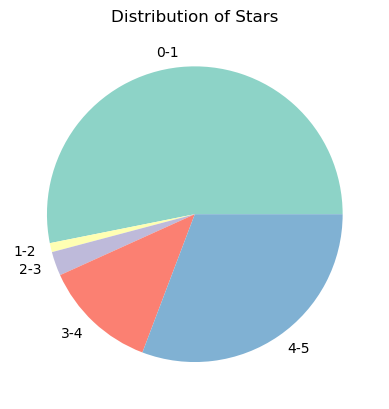

In [65]:
# Define the bin edges
bins = [0, 1, 2, 3, 4, 5]

# Create a histogram using the 'stars' column and the specified bins - chatGPT
hist, edges = np.histogram(df['stars'], bins=bins)

# Create a pie chart using the histogram data - chatGPT
plt.pie(hist, labels=[f'{bins[i]}-{bins[i+1]}' for i in range(len(hist))], colors = sns.color_palette("Set3"))

plt.title('Distribution of Stars')
plt.show()

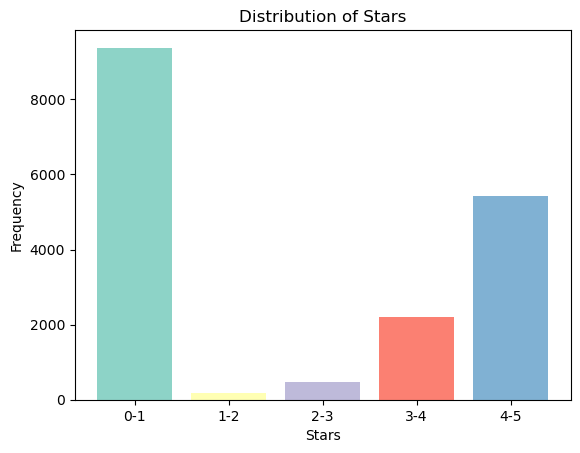

In [66]:
# Define the bin edges
bins = [0, 1, 2, 3, 4, 5]

# Create a histogram using the 'stars' column and the specified bins
hist, edges = np.histogram(df['stars'], bins=bins)

# Create a bar plot using the histogram data
plt.bar(range(len(hist)), hist, align='center', color=sns.color_palette("Set3"))

# Set the x-axis tick labels
plt.xticks(range(len(hist)), ['0-1', '1-2', '2-3', '3-4', '4-5'])

# Add labels and title
plt.xlabel('Stars')
plt.ylabel('Frequency')
plt.title('Distribution of Stars')

# Show the plot
plt.show()

It can be seen that more than half of the books have zero stars. This could indicate the unpopularity of the book or it is popular, perhaps no one who read it rated it.

# Data cleaning

### Duplicative data
We will remove all duplicate rows

In [35]:
print(df[df.duplicated()].shape)
df[df.duplicated()]

(4, 11)


,book_name,author_name,announcer_name,book_type,publishing,publishing_year,genre,stars,language,release_date,recording_length
5230,Vom Geist Europas,Gerd-Klaus Kaltenbrunner,NaN,ספר דיגיטלי,Ares Verlag,2020.0,עיון,0.00,גרמנית,תאריך פרסום\nספר דיגיטלי: 27 באוגוסט 2020,NaN
5829,So You Had To Build A Time Machine,Jason Offutt,קריינות: Emily O'Brien,ספר מוקלט בנוסף ספר דיגיטלי,NaN,NaN,מד״ב ופנטזיה,4.33,אנגלית,תאריך פרסום\nספר מוקלט: 21 ביולי 2020\nספר דיג...,11שעות 22דקות
9587,Emotives,Janelle Barker,NaN,ספר דיגיטלי,BookRix,2020.0,שירה ודרמה,0.00,אנגלית,תאריך פרסום\nספר דיגיטלי: 24 באוקטובר 2020,NaN
12220,Gun Gentlemen,Max Brand,NaN,ספר דיגיטלי,Wildside Press,2020.0,פרוזה,0.00,אנגלית,תאריך פרסום\nספר דיגיטלי: 24 באוגוסט 2020,NaN


In [70]:
df= df.drop_duplicates()
df.shape

(17640, 11)

### Missing data
We have missing data in 5 columns. 
In the columns "author_name" and "publishing" missing data will be handled by deleting the corresponding rows. In "publishing_year" I will fill the Nan in the mean value.

In [71]:
#chatgpt

df = df[(df['author_name'].notna())&(df['publishing'].notna())]
df = df.reset_index(drop=True)
# Fill NaN values with the mean
df['publishing_year'].fillna(df['publishing_year'].mean(), inplace=True)
df.shape

(17638, 11)

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17638 entries, 0 to 17637
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   book_name         17638 non-null  object 
 1   author_name       17638 non-null  object 
 2   announcer_name    10069 non-null  object 
 3   book_type         17638 non-null  object 
 4   publishing        17638 non-null  object 
 5   publishing_year   17638 non-null  float64
 6   genre             17638 non-null  object 
 7   stars             17638 non-null  float64
 8   language          17638 non-null  object 
 9   release_date      17638 non-null  object 
 10  recording_length  10067 non-null  object 
dtypes: float64(2), object(9)
memory usage: 1.5+ MB


There are still missing data in the columns announcer_name and recording_length - I will deal now just with announcer_name.

In [73]:
df['announcer_name'].fillna('No announcer', inplace=True)

# Organization and improvement of the columns

# book_type column

In [74]:
#chatgpt

# Create a boolean mask for rows that meet the condition
mask = (df['book_type'] == 'ספר דיגיטלי') | (df['book_type'] == 'ספר מוקלט')| (df['book_type'] == 'ספר מוקלט בנוסף ספר דיגיטלי')

# Apply the mask to the DataFrame
df = df[mask]

df.shape

(17606, 11)

# recording_length column
In this column, the recording length of a digital book appears as text, we would like to convert the values ​​into numbers and also distinguish between hours and minutes.
We will do this by separating into two new columns "recording_minutes" and "recording_hours" (and delete the original column because it is no longer needed).

In [75]:
#chatgpt

def extract_minutes(row):
    if isinstance(row['recording_length'], str):
        numbers = re.findall(r'\d+', row['recording_length'])
        if len(numbers) >= 2:
            return int(numbers[-1])  # Extract the last number as minutes
        elif len(numbers) == 1:
            return int(numbers[0])
    return None

def extract_hours(row):
    if isinstance(row['recording_length'], str):
        numbers = re.findall(r'\d+', row['recording_length'])
        if len(numbers) >= 2:
            return int(numbers[0])  # Extract the first number as hours
        elif len(numbers) == 1:
            return 0  # Set hour value to 0 if no hour value is present
    return None

# Extract the numeric values for minutes and hours
df['recording_minutes'] = df.apply(extract_minutes, axis=1)
df['recording_hours'] = df.apply(extract_hours, axis=1)

# Remove the original recording_length column
df.drop('recording_length', axis=1, inplace=True)
df.head()

,book_name,author_name,announcer_name,book_type,publishing,publishing_year,genre,stars,language,release_date,recording_minutes,recording_hours
0,הכינה נחמה,מאיר שלו,קריינות: מאיר שלו,ספר מוקלט,Storyside,2021.0,ילדים,4.56,עברית,תאריך פרסום\nספר מוקלט: 27 באפריל 2021,10.0,0.0
1,אבא עושה בושות,מאיר שלו,קריינות: מאיר שלו,ספר מוקלט,Storyside,2021.0,ילדים,4.29,עברית,תאריך פרסום\nספר מוקלט: 27 באפריל 2021,6.0,0.0
2,Harry Potter and the Prisoner of Azkaban,J.K. Rowling,קריינות: Stephen Fry,ספר מוקלט בנוסף ספר דיגיטלי,Pottermore,2015.0,ילדים,4.82,אנגלית,תאריך פרסום\nספר מוקלט: 20 בנובמבר 2015\nספר ד...,3.0,12.0
3,Harry Potter and the Philosopher's Stone,J.K. Rowling,קריינות: Stephen Fry,ספר מוקלט בנוסף ספר דיגיטלי,Pottermore,2015.0,ילדים,4.70,אנגלית,תאריך פרסום\nספר מוקלט: 20 בנובמבר 2015\nספר ד...,25.0,8.0
4,קרמר החתול ישן כל הזמן,מאיר שלו,קריינות: איל קיציס,ספר מוקלט,Storyside,2021.0,ילדים,4.46,עברית,תאריך פרסום\nספר מוקלט: 27 באפריל 2021,3.0,0.0


# release_date column
We will remove all the text that does not belong to the release date

In [76]:
df["release_date"] = df["release_date"].str.replace('תאריך פרסום\nספר מוקלט: ', '')
df["release_date"] = df["release_date"].str.replace('\nספר', '')
df["release_date"] = df["release_date"].str.replace("מוקלט:", '')
df["release_date"] = df["release_date"].str.replace("דיגיטלי:", '')
df.head()

,book_name,author_name,announcer_name,book_type,publishing,publishing_year,genre,stars,language,release_date,recording_minutes,recording_hours
0,הכינה נחמה,מאיר שלו,קריינות: מאיר שלו,ספר מוקלט,Storyside,2021.0,ילדים,4.56,עברית,27 באפריל 2021,10.0,0.0
1,אבא עושה בושות,מאיר שלו,קריינות: מאיר שלו,ספר מוקלט,Storyside,2021.0,ילדים,4.29,עברית,27 באפריל 2021,6.0,0.0
2,Harry Potter and the Prisoner of Azkaban,J.K. Rowling,קריינות: Stephen Fry,ספר מוקלט בנוסף ספר דיגיטלי,Pottermore,2015.0,ילדים,4.82,אנגלית,20 בנובמבר 2015 8 בדצמבר 2015,3.0,12.0
3,Harry Potter and the Philosopher's Stone,J.K. Rowling,קריינות: Stephen Fry,ספר מוקלט בנוסף ספר דיגיטלי,Pottermore,2015.0,ילדים,4.70,אנגלית,20 בנובמבר 2015 8 בדצמבר 2015,25.0,8.0
4,קרמר החתול ישן כל הזמן,מאיר שלו,קריינות: איל קיציס,ספר מוקלט,Storyside,2021.0,ילדים,4.46,עברית,27 באפריל 2021,3.0,0.0



Now we will convert the dates from Hebrew to English

In [77]:
month_dict = {"בינואר":"January",
              "בפברואר":"February", 
              "במרץ":"March", 
              "באפריל":"April",
              "במאי":"May",
              "ביוני":"June", 
              "ביולי":"July",
              "באוגוסט":"August",
              "בספטמבר":"September",
              "באוקטובר":"October",
              "בנובמבר":"November",
              "בדצמבר":"December"}
for key, val in month_dict.items():
    df["release_date"] = df["release_date"].str.replace(key,val)
df.head()

,book_name,author_name,announcer_name,book_type,publishing,publishing_year,genre,stars,language,release_date,recording_minutes,recording_hours
0,הכינה נחמה,מאיר שלו,קריינות: מאיר שלו,ספר מוקלט,Storyside,2021.0,ילדים,4.56,עברית,27 April 2021,10.0,0.0
1,אבא עושה בושות,מאיר שלו,קריינות: מאיר שלו,ספר מוקלט,Storyside,2021.0,ילדים,4.29,עברית,27 April 2021,6.0,0.0
2,Harry Potter and the Prisoner of Azkaban,J.K. Rowling,קריינות: Stephen Fry,ספר מוקלט בנוסף ספר דיגיטלי,Pottermore,2015.0,ילדים,4.82,אנגלית,20 November 2015 8 December 2015,3.0,12.0
3,Harry Potter and the Philosopher's Stone,J.K. Rowling,קריינות: Stephen Fry,ספר מוקלט בנוסף ספר דיגיטלי,Pottermore,2015.0,ילדים,4.70,אנגלית,20 November 2015 8 December 2015,25.0,8.0
4,קרמר החתול ישן כל הזמן,מאיר שלו,קריינות: איל קיציס,ספר מוקלט,Storyside,2021.0,ילדים,4.46,עברית,27 April 2021,3.0,0.0



Books that are both recorded and digital have two dates so we I leave only the first one

In [78]:
def extract_first_date(date_string):
    dates = re.findall(r'\d+\s\w+\s\d+', date_string)  # Extract date patterns (e.g., "20 November 2015")
    if dates:
        return parse(dates[0])
    else:
        return None

df["release_date"] = df["release_date"].apply(lambda x: extract_first_date(x) if isinstance(x, str) else x)
df.head()

,book_name,author_name,announcer_name,book_type,publishing,publishing_year,genre,stars,language,release_date,recording_minutes,recording_hours
0,הכינה נחמה,מאיר שלו,קריינות: מאיר שלו,ספר מוקלט,Storyside,2021.0,ילדים,4.56,עברית,2021-04-27,10.0,0.0
1,אבא עושה בושות,מאיר שלו,קריינות: מאיר שלו,ספר מוקלט,Storyside,2021.0,ילדים,4.29,עברית,2021-04-27,6.0,0.0
2,Harry Potter and the Prisoner of Azkaban,J.K. Rowling,קריינות: Stephen Fry,ספר מוקלט בנוסף ספר דיגיטלי,Pottermore,2015.0,ילדים,4.82,אנגלית,2015-11-20,3.0,12.0
3,Harry Potter and the Philosopher's Stone,J.K. Rowling,קריינות: Stephen Fry,ספר מוקלט בנוסף ספר דיגיטלי,Pottermore,2015.0,ילדים,4.70,אנגלית,2015-11-20,25.0,8.0
4,קרמר החתול ישן כל הזמן,מאיר שלו,קריינות: איל קיציס,ספר מוקלט,Storyside,2021.0,ילדים,4.46,עברית,2021-04-27,3.0,0.0


### I will add a column that will represent how many days have passed since the release date until today

In [79]:
current_date = datetime.datetime.now()
df.insert(10, "days_from_release", df["release_date"].apply(lambda x: (current_date - x).days if isinstance(x, datetime.datetime) else x), True)
df.head()

,book_name,author_name,announcer_name,book_type,publishing,publishing_year,genre,stars,language,release_date,days_from_release,recording_minutes,recording_hours
0,הכינה נחמה,מאיר שלו,קריינות: מאיר שלו,ספר מוקלט,Storyside,2021.0,ילדים,4.56,עברית,2021-04-27,779,10.0,0.0
1,אבא עושה בושות,מאיר שלו,קריינות: מאיר שלו,ספר מוקלט,Storyside,2021.0,ילדים,4.29,עברית,2021-04-27,779,6.0,0.0
2,Harry Potter and the Prisoner of Azkaban,J.K. Rowling,קריינות: Stephen Fry,ספר מוקלט בנוסף ספר דיגיטלי,Pottermore,2015.0,ילדים,4.82,אנגלית,2015-11-20,2764,3.0,12.0
3,Harry Potter and the Philosopher's Stone,J.K. Rowling,קריינות: Stephen Fry,ספר מוקלט בנוסף ספר דיגיטלי,Pottermore,2015.0,ילדים,4.70,אנגלית,2015-11-20,2764,25.0,8.0
4,קרמר החתול ישן כל הזמן,מאיר שלו,קריינות: איל קיציס,ספר מוקלט,Storyside,2021.0,ילדים,4.46,עברית,2021-04-27,779,3.0,0.0


# announcer_name column
I want to get rid of all the unnecessary text that does not belong to the announcer name.

In [80]:
df["announcer_name"] = df["announcer_name"].str.replace('קריינות:', '')
df.head()

,book_name,author_name,announcer_name,book_type,publishing,publishing_year,genre,stars,language,release_date,days_from_release,recording_minutes,recording_hours
0,הכינה נחמה,מאיר שלו,מאיר שלו,ספר מוקלט,Storyside,2021.0,ילדים,4.56,עברית,2021-04-27,779,10.0,0.0
1,אבא עושה בושות,מאיר שלו,מאיר שלו,ספר מוקלט,Storyside,2021.0,ילדים,4.29,עברית,2021-04-27,779,6.0,0.0
2,Harry Potter and the Prisoner of Azkaban,J.K. Rowling,Stephen Fry,ספר מוקלט בנוסף ספר דיגיטלי,Pottermore,2015.0,ילדים,4.82,אנגלית,2015-11-20,2764,3.0,12.0
3,Harry Potter and the Philosopher's Stone,J.K. Rowling,Stephen Fry,ספר מוקלט בנוסף ספר דיגיטלי,Pottermore,2015.0,ילדים,4.70,אנגלית,2015-11-20,2764,25.0,8.0
4,קרמר החתול ישן כל הזמן,מאיר שלו,איל קיציס,ספר מוקלט,Storyside,2021.0,ילדים,4.46,עברית,2021-04-27,779,3.0,0.0


#### 
I see in the column "author_name" that I have the value "אני רוצה לנסות!" - I will remove all rows with that value.

In [81]:
df = df[df["author_name"] != "אני רוצה לנסות!"]
df.shape

(17478, 13)

# genre column & language column & book_type
I will transfer the genres and the languages to English

In [82]:
genre_dict = {"ילדים":"Kids",
             "ביוגרפיות":"Biographies",
             "פשע":"Crime",
             "עסקים וכלכלה":"Business and economy",
             "ארוטיקה":"Erotica",
             "עיון":"Nonfiction",
             "מד״ב ופנטזיה":"Science fiction and fantasy",
             "היסטוריה":"History",
             "קלאסיקות":"Classics",
             "שירה ודרמה":"Poetry and drama",
             "סיפורים קצרים":"Short stories",
             "התפתחות אישית":"Personal development",
             "פרוזה":"Prose",
             "שפות":"Languages",
             "מותחנים":"Thrillers",
             "נוער צעיר ונוער בוגר":"Young youth and mature youth",
             "רומנטיקה":"romanticism",
             "דת ורוחניות":"Religion and spirituality"}
for key, val in genre_dict.items():
    df["genre"] = df["genre"].replace(key,val)

In [83]:
book_type_dict = {df["book_type"].unique()[1]:"Aoudio book & Digital book",df["book_type"].unique()[2]:"Digital book",df["book_type"].unique()[0]:"Aoudio book"}
for key, val in book_type_dict.items():
    df["book_type"] = df["book_type"].str.replace(key,val)

In [84]:
language_dict = {"עברית":"Hebrew",
             "אנגלית":"English",
             "רוסית":"Russian",
             "גרמנית":"German",
             "איטלקית":"Italian",
             "פולנית":"Polish",
             "ספרדית":"Spanish",
             "צרפתית":"French"}
for key, val in language_dict.items():
    df["language"] = df["language"].str.replace(key,val)
df.head()

,book_name,author_name,announcer_name,book_type,publishing,publishing_year,genre,stars,language,release_date,days_from_release,recording_minutes,recording_hours
0,הכינה נחמה,מאיר שלו,מאיר שלו,Aoudio book,Storyside,2021.0,Kids,4.56,Hebrew,2021-04-27,779,10.0,0.0
1,אבא עושה בושות,מאיר שלו,מאיר שלו,Aoudio book,Storyside,2021.0,Kids,4.29,Hebrew,2021-04-27,779,6.0,0.0
2,Harry Potter and the Prisoner of Azkaban,J.K. Rowling,Stephen Fry,Aoudio book & Digital book,Pottermore,2015.0,Kids,4.82,English,2015-11-20,2764,3.0,12.0
3,Harry Potter and the Philosopher's Stone,J.K. Rowling,Stephen Fry,Aoudio book & Digital book,Pottermore,2015.0,Kids,4.70,English,2015-11-20,2764,25.0,8.0
4,קרמר החתול ישן כל הזמן,מאיר שלו,איל קיציס,Aoudio book,Storyside,2021.0,Kids,4.46,Hebrew,2021-04-27,779,3.0,0.0


# Fill in missing data
Handling the missing data of the new columns

In [85]:
df['recording_hours'] = df['recording_hours'].fillna(0)
df['recording_minutes'] = df['recording_minutes'].fillna(0)

### Saving before one-hot

In [86]:
csv_after_cleaning = df.to_csv('df_after_cleaning_no_dummies.csv',index = False, encoding='utf-8')

In [87]:
df_no_dummies = pd.read_csv("df_after_cleaning_no_dummies.csv")
print(df_no_dummies.shape)
df_no_dummies.head()

(17478, 13)


,book_name,author_name,announcer_name,book_type,publishing,publishing_year,genre,stars,language,release_date,days_from_release,recording_minutes,recording_hours
0,הכינה נחמה,מאיר שלו,מאיר שלו,Aoudio book,Storyside,2021.0,Kids,4.56,Hebrew,2021-04-27,779,10.0,0.0
1,אבא עושה בושות,מאיר שלו,מאיר שלו,Aoudio book,Storyside,2021.0,Kids,4.29,Hebrew,2021-04-27,779,6.0,0.0
2,Harry Potter and the Prisoner of Azkaban,J.K. Rowling,Stephen Fry,Aoudio book & Digital book,Pottermore,2015.0,Kids,4.82,English,2015-11-20,2764,3.0,12.0
3,Harry Potter and the Philosopher's Stone,J.K. Rowling,Stephen Fry,Aoudio book & Digital book,Pottermore,2015.0,Kids,4.70,English,2015-11-20,2764,25.0,8.0
4,קרמר החתול ישן כל הזמן,מאיר שלו,איל קיציס,Aoudio book,Storyside,2021.0,Kids,4.46,Hebrew,2021-04-27,779,3.0,0.0


# 

# Visualization and EDA

### One-dimensional visualizations

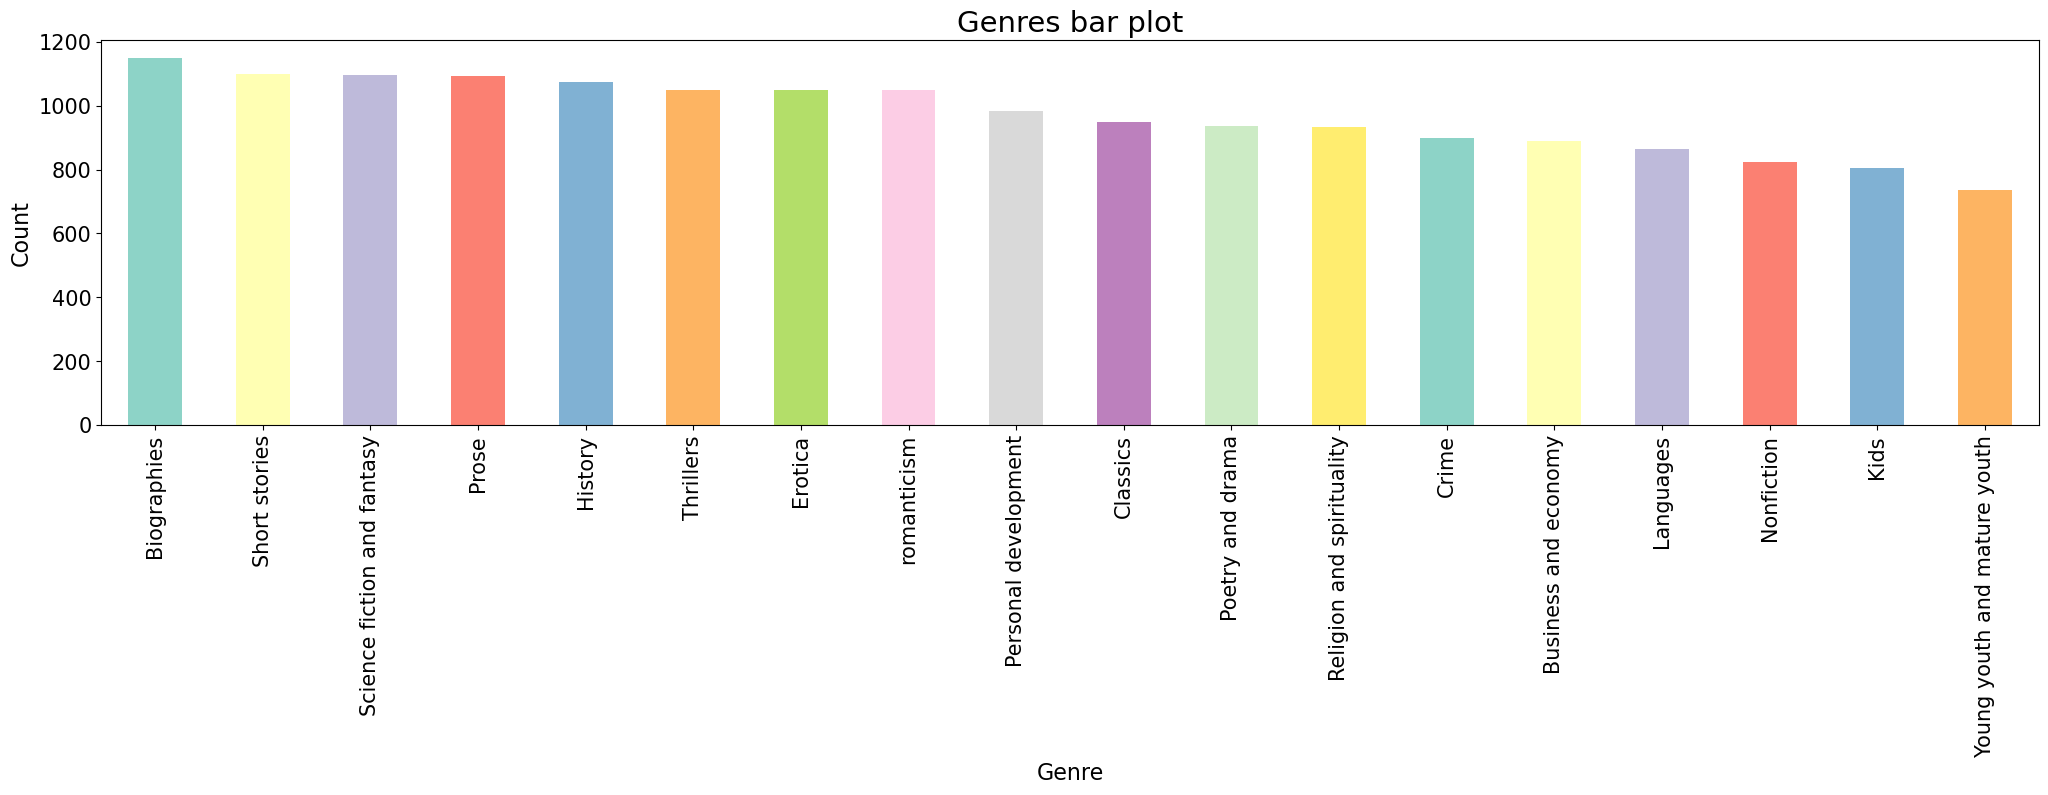

In [88]:
fig, ax = plt.subplots(figsize = (25,5))
fig = df_no_dummies['genre'].value_counts().plot(kind='bar', rot=90, fontsize=15, color = sns.color_palette("Set3"))
ax.set_xlabel('Genre', fontsize=16)
ax.set_ylabel('Count', fontsize=16)
fig.set_title("Genres bar plot", fontsize=21)
plt.show()

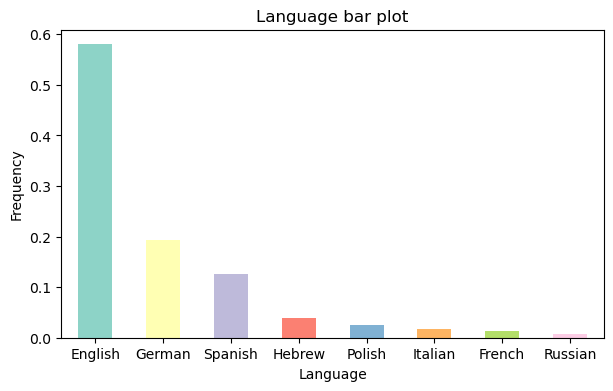

In [89]:
fig, ax = plt.subplots(figsize=(7, 4))
language_freq = df_no_dummies['language'].value_counts(normalize=True)
language_freq.plot(kind='bar', xlabel='Language', ylabel='Frequency', rot=0, color=sns.color_palette("Set3"))
ax.set_title("Language bar plot")
plt.show()

### From this plot we can see that Russian, Frebch, Italian and Polish have a low frequency in the data, so I will drop them

In [90]:
# Drop rows where language is Italian or French
df_no_dummies = df_no_dummies[df_no_dummies['language'].isin(['Russian','French', 'Italian', 'Polish']) == False]
df_no_dummies.shape

(16384, 13)

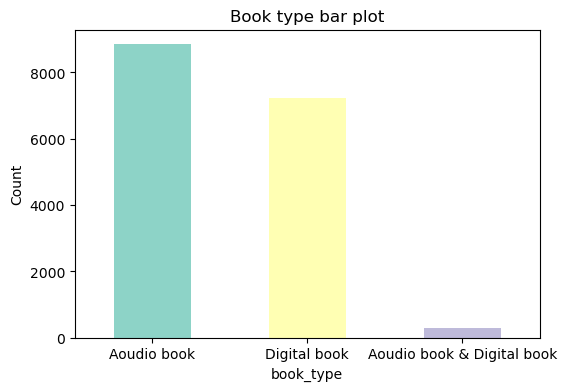

In [91]:
fig, ax = plt.subplots(figsize = (6,4))
fig = df_no_dummies['book_type'].value_counts().plot(kind='bar', xlabel='book_type', ylabel='Count', rot=0, color = sns.color_palette("Set3"))
fig.set_title("Book type bar plot")
plt.show()

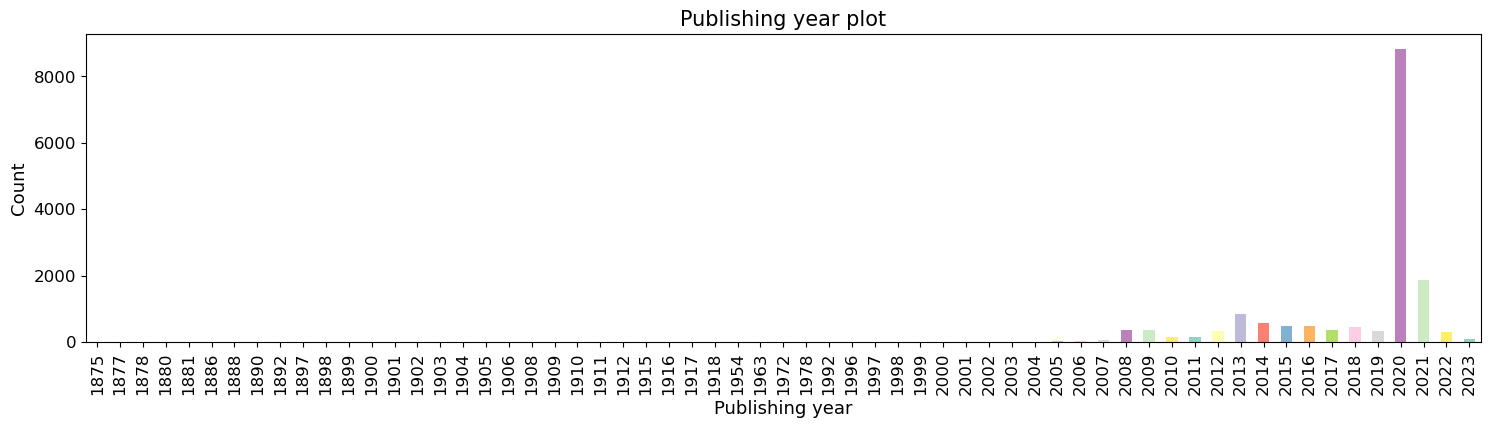

In [92]:
fig, ax = plt.subplots(figsize=(18, 4))
year_counts = df_no_dummies['publishing_year'].value_counts().sort_index()

fig = year_counts.plot(kind='bar', rot=90, fontsize=12, color = sns.color_palette("Set3")
)
fig.set_title("Publishing year plot", fontsize=15)
ax.set_xlabel('Publishing year', fontsize=13)
ax.set_ylabel('Count', fontsize=13)

# Sort the x-axis labels (years)
plt.xticks(range(len(year_counts.index)), sorted(map(int, year_counts.index)))

plt.show()

### We can see that till 2008 we do not have a lot of books so I will drop those years

In [93]:
df_no_dummies = df_no_dummies[df_no_dummies['publishing_year'] > 2007]
df_no_dummies.shape

(16129, 13)

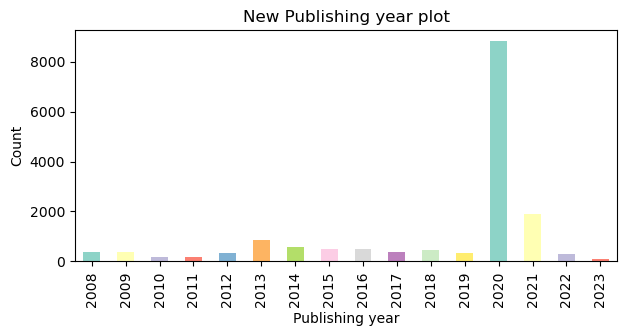

In [95]:
fig, ax = plt.subplots(figsize=(7, 3))
year_counts = df_no_dummies['publishing_year'].value_counts().sort_index()

fig = year_counts.plot(kind='bar', rot=90, fontsize=10, color = sns.color_palette("Set3"))
fig.set_title("New Publishing year plot", fontsize=12)
ax.set_xlabel('Publishing year', fontsize=10)
ax.set_ylabel('Count', fontsize=10)

# Sort the x-axis labels (years)
plt.xticks(range(len(year_counts.index)), sorted(map(int, year_counts.index)))

plt.show()

### Heat - map

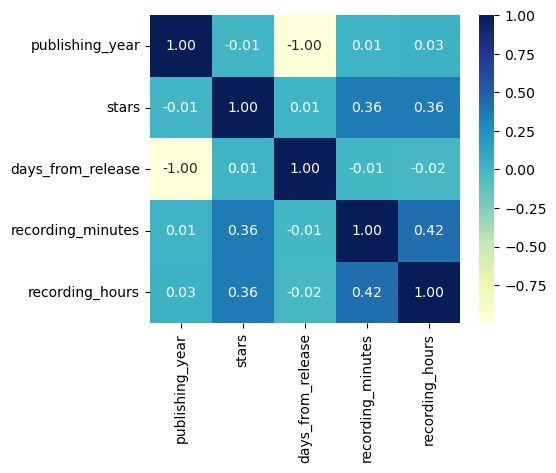

In [96]:
# Generate a correlation matrix for the DataFrame
correlation_matrix = df_no_dummies.corr()

# Create a heatmap with correlation values
plt.figure(figsize=(5, 4))  
sns.heatmap(correlation_matrix, cmap="YlGnBu", annot=True, fmt=".2f")  # Add annot=True and fmt=".2f" for displaying values

# Show the plot
plt.show()

#### It can be seen that there are no strong correlations except for "days_from_release" and "publishing_year" which have an inverse correlation.

### Two-dimensional visualizations

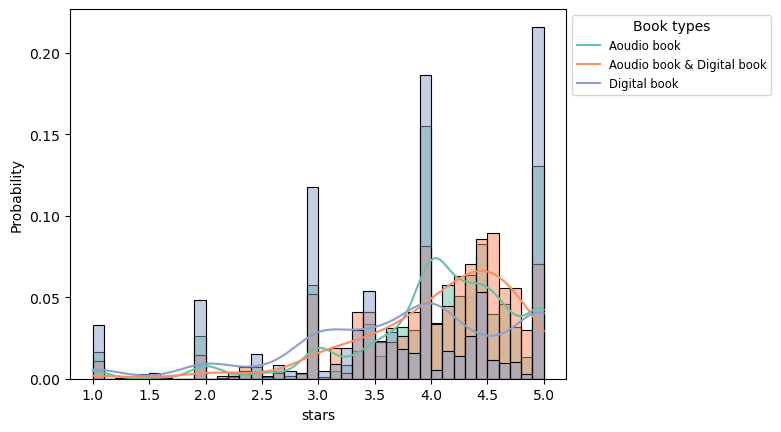

In [97]:
fig, ax = plt.subplots()

types = df_no_dummies["book_type"].unique()
colors = sns.color_palette("Set2", len(types))

for i, b_type in enumerate(types):
    types_df = df_no_dummies[(df_no_dummies["book_type"] == b_type) & (df_no_dummies["stars"] > 0)]
    sns.histplot(data=types_df, x="stars", kde=True, color=colors[i], binwidth=0.1, stat="probability")

ax.legend(types, title='Book types', fontsize='small', bbox_to_anchor=(1, 1))

plt.show()

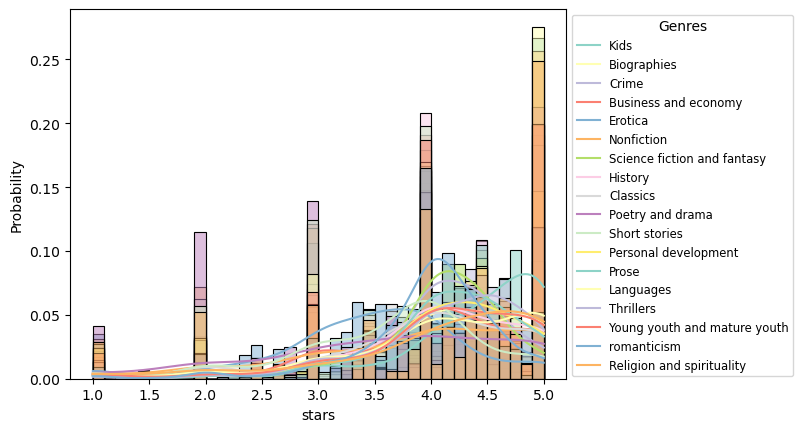

In [98]:
fig, ax = plt.subplots()

genres = df_no_dummies["genre"].unique()
colors = sns.color_palette("Set3", len(genres))

for i, genre in enumerate(genres):
    genre_df = df_no_dummies[(df_no_dummies["genre"] == genre) & (df_no_dummies["stars"] > 0)]
    sns.histplot(data=genre_df, x="stars", kde=True, color=colors[i], binwidth=0.1, stat="probability")

ax.legend(genres, title='Genres', fontsize='small', bbox_to_anchor=(1, 1))

plt.show()

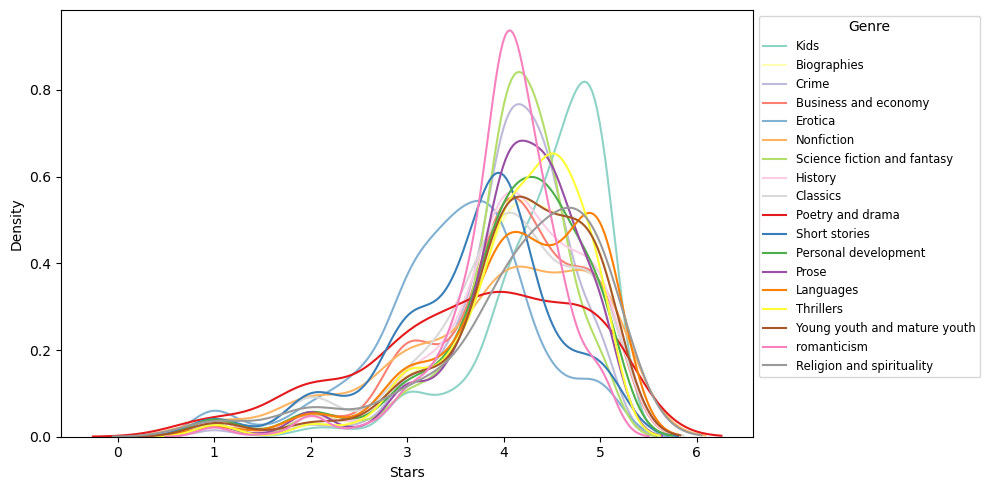

In [99]:
fig, ax = plt.subplots(figsize=(10, 5))

gen = df_no_dummies["genre"].unique()
colors = sns.color_palette("Set3", n_colors=len(gen)//2) + sns.color_palette("Set1", n_colors=len(gen)//2)

for i, genr in enumerate(gen):
    gen_df = df_no_dummies[(df_no_dummies["genre"] == genr) & (df_no_dummies["stars"] > 0)]
    sns.kdeplot(data=gen_df, x="stars", color=colors[i], ax=ax, label=genr)

ax.legend(title='Genre', fontsize='small', bbox_to_anchor=(1, 1))
ax.set_xlabel("Stars")
ax.set_ylabel("Density")

plt.tight_layout()
plt.show()


### Here we can see that some genres have a similar distribution: 
####                                                                                                            1. Science fiction and fantsy(light green) - Crime(light purple)
####                                                                                                            2. Personal development(green) - Prose(purple)
####                                                                                                            3. Young youth and mature youth(brown) - Biographies(light yellow)
####                                                                                                            4. History(light pink) - Classics(light gray) - Business and economy(reddish orange)

In [100]:
genre_mapping = {
    'Science fiction and fantasy': 'Science fiction and fantasy & Crime',
    'Crime': 'Science fiction and fantasy & Crime',
    'Personal development': 'Personal development & Prose',
    'Prose': 'Personal development & Prose',
    'Young youth and mature youth': 'Young and mature youth & Biographies',
    'Biographies': 'Young and mature youth & Biographies',
    'History': 'History & Classics & Business and economy', 
    'Classics': 'History & Classics & Business and economy',
    'Business and economy': 'History & Classics & Business and economy'
}

# Replace the genres in the "genre" column based on the mapping dictionary
df_no_dummies['genre'] = df_no_dummies['genre'].replace(genre_mapping)

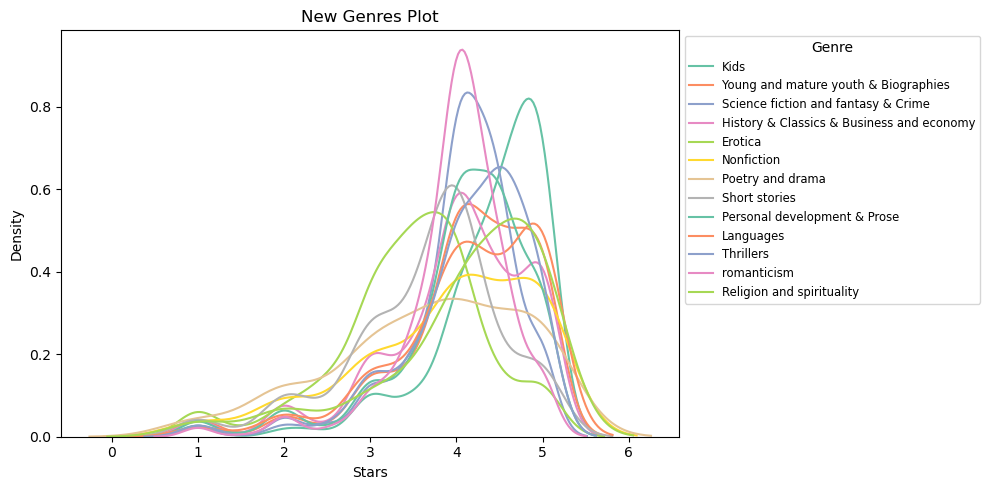

In [101]:
fig, ax = plt.subplots(figsize=(10, 5))

gen = df_no_dummies["genre"].unique()
colors = sns.color_palette("Set2", len(gen))

for i, genr in enumerate(gen):
    gen_df = df_no_dummies[(df_no_dummies["genre"] == genr) & (df_no_dummies["stars"] > 0)]
    sns.kdeplot(data=gen_df, x="stars", color=colors[i], ax=ax, label=genr)

ax.set_title("New Genres Plot") 
ax.legend(title='Genre', fontsize='small', bbox_to_anchor=(1, 1))
ax.set_xlabel("Stars")
ax.set_ylabel("Density")

plt.tight_layout()
plt.show()

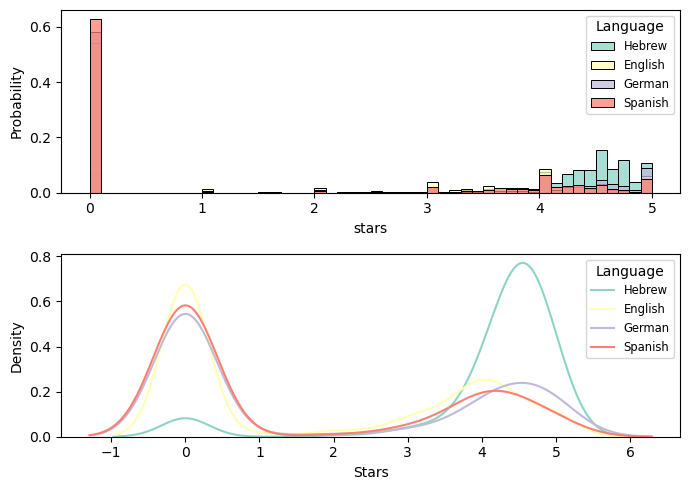

In [102]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5))

lan = df_no_dummies["language"].unique()
colors = sns.color_palette("Set3", len(lan))

for i, lang in enumerate(lan):
    lang_df = df_no_dummies[(df_no_dummies["language"] == lang) & (df_no_dummies["stars"] >= 0)]
    sns.histplot(data=lang_df, x="stars", kde=False, color=colors[i], binwidth=0.1, stat="probability", ax=ax1)
    sns.kdeplot(data=lang_df, x="stars", color=colors[i], ax=ax2)

ax1.legend(lan, title='Language', fontsize='small', bbox_to_anchor=(1, 1))
ax2.legend(lan, title='Language', fontsize='small', bbox_to_anchor=(1, 1))

ax1.set_ylabel("Probability")
ax2.set_xlabel("Stars")
ax2.set_ylabel("Density")

plt.tight_layout()
plt.show()


### It can be seen that Spanish  is distributed similarly to English Therefore I will treat them as one language

In [103]:
genre_mapping = {
    'English': 'English & Spanish',
    'Spanish': 'English & Spanish'
}

# Replace the genres in the "language" column based on the mapping dictionary
df_no_dummies['language'] = df_no_dummies['language'].replace(genre_mapping)

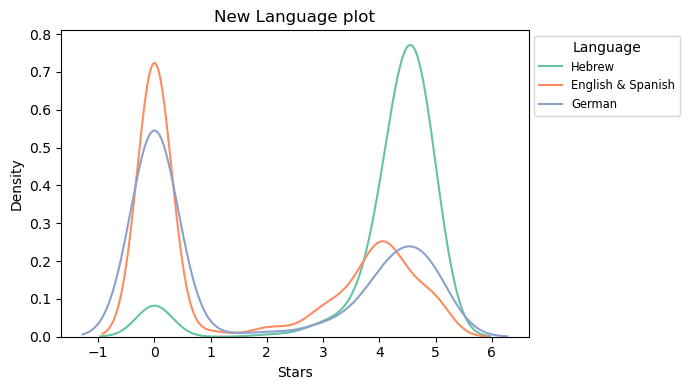

In [104]:
fig, ax = plt.subplots(figsize=(7, 4))

lan = df_no_dummies["language"].unique()
colors = sns.color_palette("Set2", len(lan))

for i, lang in enumerate(lan):
    lan_df = df_no_dummies[(df_no_dummies["language"] == lang) & (df_no_dummies["stars"] >= 0)]
    sns.kdeplot(data=lan_df, x="stars", color=colors[i], ax=ax, label=lang)

ax.legend(title='Language', fontsize='small', bbox_to_anchor=(1, 1))
ax.set_xlabel("Stars")
ax.set_ylabel("Density")
ax.set_title("New Language plot")

plt.tight_layout()
plt.show()

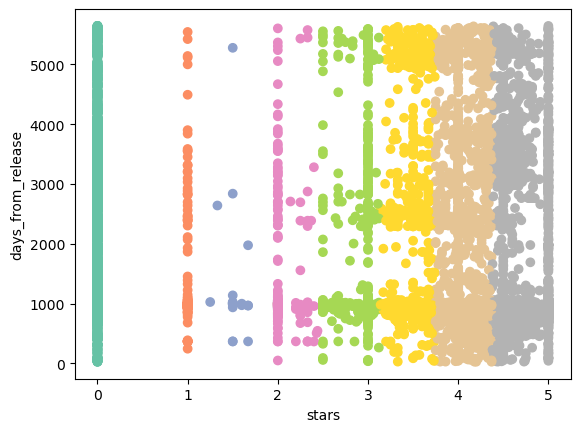

In [105]:
from matplotlib.cm import get_cmap
fig= plt.figure()
ax= plt.axes()
cmap = get_cmap('Set2')
scatter = ax.scatter(df_no_dummies["stars"], df_no_dummies["days_from_release"], c=df_no_dummies["stars"], cmap=cmap)
plt.xlabel('stars')
plt.ylabel('days_from_release')
plt.show()

### From this plot you can see that there are outliers, I will deal with them:

# Outliers

In [106]:
df_no_dummies.describe()

,publishing_year,stars,days_from_release,recording_minutes,recording_hours
count,16129.000000,16129.000000,16129.000000,16129.00000,16129.000000
mean,2018.265361,1.834810,1673.611693,16.18073,2.821006
std,3.479552,2.070631,1285.809341,19.44125,4.571483
min,2008.000000,0.000000,25.000000,0.00000,0.000000
25%,2017.000000,0.000000,954.000000,0.00000,0.000000
50%,2020.000000,0.000000,1001.000000,6.00000,0.000000
75%,2020.000000,4.000000,2176.000000,32.00000,5.000000
max,2023.000000,5.000000,5644.000000,59.00000,73.000000


<AxesSubplot:xlabel='days_from_release'>

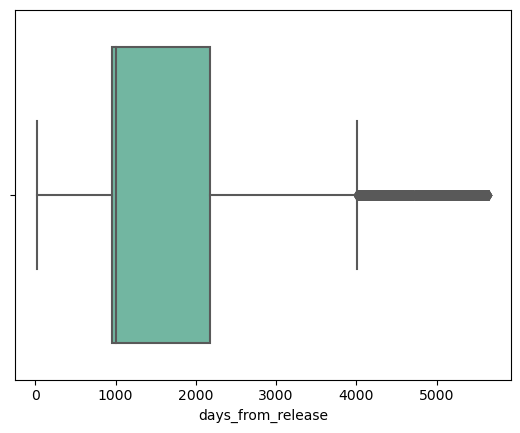

In [107]:
sns.boxplot(x=df_no_dummies["days_from_release"], palette='Set2')

<AxesSubplot:xlabel='publishing_year'>

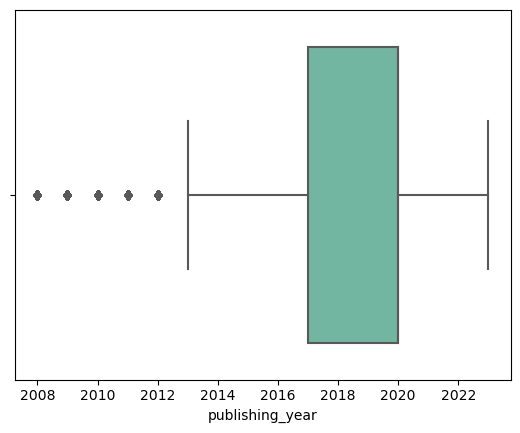

In [108]:
sns.boxplot(x = df_no_dummies["publishing_year"], palette='Set2')

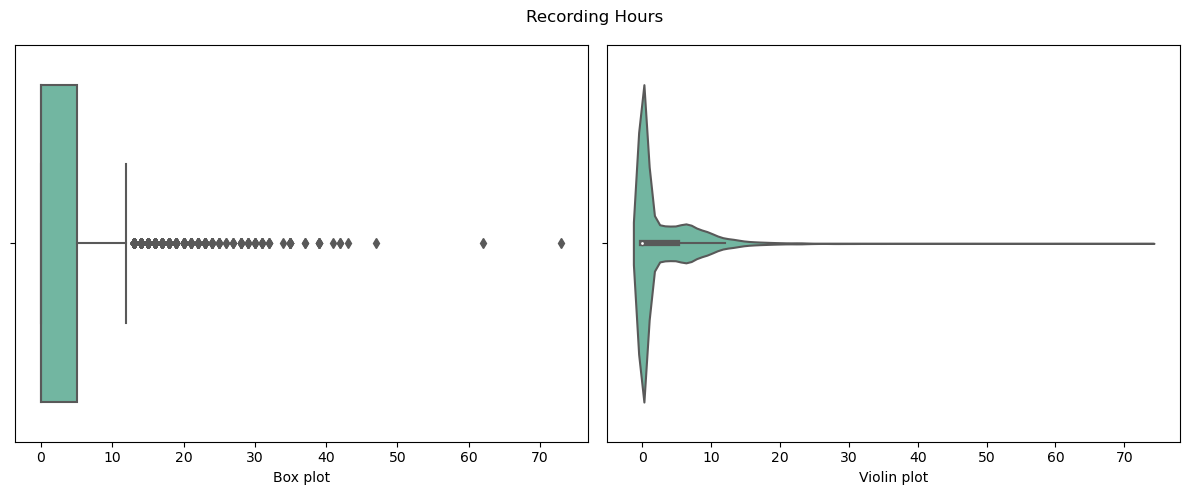

In [113]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.boxplot(x=df_no_dummies["recording_hours"], palette='Set2', ax=axes[0])
axes[0].set_xlabel("Box plot")
axes[0].set_ylabel("")

sns.violinplot(x=df_no_dummies["recording_hours"], palette='Set2', ax=axes[1])
axes[1].set_xlabel("Violin plot")
axes[1].set_ylabel("")

fig.suptitle("Recording Hours")

plt.tight_layout()
plt.show()

In [114]:
# Define the columns to handle outliers
columns_to_handle = ['publishing_year', 'days_from_release', 'recording_hours']

# Iterate over the specified columns and handle outliers
for column in columns_to_handle:
    # Calculate the quartiles
    q1 = df_no_dummies[column].quantile(0.25)
    q3 =df_no_dummies[column].quantile(0.75)
    
    # Calculate the IQR
    iqr = q3 - q1
    
    # Define the upper and lower bounds
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    
    # Identify outliers
    outliers = df_no_dummies[(df_no_dummies[column] < lower_bound) | (df_no_dummies[column] > upper_bound)]
    
    # Replace outliers with the median value
    median_value = df_no_dummies[column].median()
    df_no_dummies.loc[(df_no_dummies[column] < lower_bound) | (df_no_dummies[column] > upper_bound), column] = median_value
    
    df_no_dummies = df_no_dummies.dropna()

In [115]:
df_no_dummies.describe()

,publishing_year,stars,days_from_release,recording_minutes,recording_hours
count,16129.000000,16129.000000,16129.000000,16129.00000,16129.000000
mean,2019.166346,1.834810,1381.598115,16.18073,2.127720
std,2.238821,2.070631,884.471985,19.44125,3.268614
min,2013.000000,0.000000,25.000000,0.00000,0.000000
25%,2020.000000,0.000000,954.000000,0.00000,0.000000
50%,2020.000000,0.000000,1001.000000,6.00000,0.000000
75%,2020.000000,4.000000,1165.000000,32.00000,4.000000
max,2023.000000,5.000000,4006.000000,59.00000,12.000000


In [116]:
df_no_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16129 entries, 0 to 17477
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   book_name          16129 non-null  object 
 1   author_name        16129 non-null  object 
 2   announcer_name     16129 non-null  object 
 3   book_type          16129 non-null  object 
 4   publishing         16129 non-null  object 
 5   publishing_year    16129 non-null  float64
 6   genre              16129 non-null  object 
 7   stars              16129 non-null  float64
 8   language           16129 non-null  object 
 9   release_date       16129 non-null  object 
 10  days_from_release  16129 non-null  int64  
 11  recording_minutes  16129 non-null  float64
 12  recording_hours    16129 non-null  float64
dtypes: float64(4), int64(1), object(8)
memory usage: 1.7+ MB


# One-Hot

In [117]:
df_lang1 = pd.get_dummies(df_no_dummies["language"])
df_book_type1 = pd.get_dummies(df_no_dummies["book_type"])
df_genre1 = pd.get_dummies(df_no_dummies["genre"])
df_onehot_no_aap = pd.concat([df_no_dummies, df_lang1, df_book_type1, df_genre1], axis=1)
df_onehot_no_aap.drop(['author_name','announcer_name', 'genre',"book_type","language","publishing"], axis=1, inplace=True)
print(df_onehot_no_aap.shape)
df_onehot_no_aap.head()

(16129, 26)


,book_name,publishing_year,stars,release_date,days_from_release,recording_minutes,recording_hours,English & Spanish,German,Hebrew,...,Languages,Nonfiction,Personal development & Prose,Poetry and drama,Religion and spirituality,Science fiction and fantasy & Crime,Short stories,Thrillers,Young and mature youth & Biographies,romanticism
0,הכינה נחמה,2021.0,4.56,2021-04-27,779,10.0,0.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,אבא עושה בושות,2021.0,4.29,2021-04-27,779,6.0,0.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,Harry Potter and the Prisoner of Azkaban,2015.0,4.82,2015-11-20,2764,3.0,12.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Harry Potter and the Philosopher's Stone,2015.0,4.70,2015-11-20,2764,25.0,8.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,קרמר החתול ישן כל הזמן,2021.0,4.46,2021-04-27,779,3.0,0.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [118]:
csv_onehot_no_aap = df_onehot_no_aap.to_csv('df_onehot_no_aap.csv',index = False, encoding='utf-8')

In [119]:
df_26_columns = pd.read_csv("df_onehot_no_aap.csv")

### I want to run one-hot on additional columns, but this will increase the number of columns significantly, so I will try to reduce the number of columns

In [120]:
#chatGPT
author_counts = df_no_dummies['author_name'].value_counts()  # Count the occurrences of each value
announcer_counts = df_no_dummies['announcer_name'].value_counts() 
publishing_counts = df_no_dummies['publishing'].value_counts() 

In [155]:
df_filtered3 = df_no_dummies[df_no_dummies['author_name'].isin(author_counts[author_counts > 1].index) & df_no_dummies['announcer_name'].isin(announcer_counts[announcer_counts > 21].index) & df_no_dummies['publishing'].isin(publishing_counts[publishing_counts > 5].index)]
df_filtered3 = df_filtered3.reset_index(drop=True)
df_lang3 = pd.get_dummies(df_filtered3["language"])
df_author3 = pd.get_dummies(df_filtered3["author_name"])
df_announcer3 = pd.get_dummies(df_filtered3["announcer_name"])
df_book_type3 = pd.get_dummies(df_filtered3["book_type"])
df_genre3 = pd.get_dummies(df_filtered3["genre"])
df_publish3 = pd.get_dummies(df_filtered3["publishing"])
df_after_onehot_with_app3 = pd.concat([df_filtered3, df_lang3, df_author3, df_announcer3, df_book_type3, df_genre3, df_publish3], axis=1)
df_after_onehot_with_app3.drop(['author_name','announcer_name', 'genre',"book_type","language","publishing"], axis=1, inplace=True)
print(df_after_onehot_with_app3.shape)
df_after_onehot_with_app3.head()

(4262, 922)


,book_name,publishing_year,stars,release_date,days_from_release,recording_minutes,recording_hours,English & Spanish,German,Hebrew,...,Wordsworth Editions,blue panther books,e-artnow,l-Aleph,mehrbuch,mindplusfood,mysteriouspress.com,p.machinery,אדל,יהלומים
0,חבורת כוח המוח (10) ותעלומת העטלף השחור,2021.0,4.67,2021-03-29,808,18.0,2.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,חבורת כוח המוח (13) בעקבות גנבי האופניים,2021.0,4.73,2021-03-29,808,5.0,2.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,חבורת כוח המוח (14) - ורוח הרפאים,2021.0,4.70,2021-03-29,808,14.0,2.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,חבורת כוח המוח (17) - והקלף המקולל,2021.0,4.87,2021-03-29,808,7.0,2.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,חבורת כוח המוח (7) בעקבות הכסף האבוד,2021.0,5.00,2021-03-29,808,52.0,1.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [138]:
csv_onehot_with_app_922 = df_after_onehot_with_app3.to_csv('csv_onehot_with_app_922.csv',index = False, encoding='utf-8')

In [139]:
df_922_columns = pd.read_csv("csv_onehot_with_app_922.csv")

In [179]:
df_filtered4 = df_no_dummies[df_no_dummies['author_name'].isin(author_counts[author_counts > 1].index) & df_no_dummies['announcer_name'].isin(announcer_counts[announcer_counts > 11].index) & df_no_dummies['publishing'].isin(publishing_counts[publishing_counts > 5].index)]
df_filtered4 = df_filtered4.reset_index(drop=True)
df_lang4 = pd.get_dummies(df_filtered4["language"])
df_author4 = pd.get_dummies(df_filtered4["author_name"])
df_announcer4 = pd.get_dummies(df_filtered4["announcer_name"])
df_book_type4 = pd.get_dummies(df_filtered4["book_type"])
df_genre4 = pd.get_dummies(df_filtered4["genre"])
df_publish4 = pd.get_dummies(df_filtered4["publishing"])
df_after_onehot_with_app4 = pd.concat([df_filtered4, df_lang4, df_author4, df_announcer4, df_book_type4, df_genre4, df_publish4], axis=1)
df_after_onehot_with_app4.drop(['author_name','announcer_name', 'genre',"book_type","language","publishing"], axis=1, inplace=True)
print(df_after_onehot_with_app4.shape)
df_after_onehot_with_app4.head()

(4999, 1105)


,book_name,publishing_year,stars,release_date,days_from_release,recording_minutes,recording_hours,English & Spanish,German,Hebrew,...,YOYO USA,blue panther books,e-artnow,l-Aleph,mehrbuch,mindplusfood,mysteriouspress.com,p.machinery,אדל,יהלומים
0,מנהרת הזמן (2): מבצע חומה ומגדל,2022.0,4.68,2022-02-14,486,25.0,1.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,חבורת כוח המוח (10) ותעלומת העטלף השחור,2021.0,4.67,2021-03-29,808,18.0,2.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,מנהרת הזמן (1): ירושלים במצור,2022.0,4.60,2022-02-15,485,18.0,1.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,חבורת כוח המוח (13) בעקבות גנבי האופניים,2021.0,4.73,2021-03-29,808,5.0,2.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,חבורת כוח המוח (14) - ורוח הרפאים,2021.0,4.70,2021-03-29,808,14.0,2.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [183]:
csv_onehot_with_app_1105 = df_after_onehot_with_app4.to_csv('csv_onehot_with_app_1105.csv',index = False, encoding='utf-8')

In [184]:
df_1105_columns = pd.read_csv("csv_onehot_with_app_1105.csv")

# Machine Learning

###  Regression

In [136]:
import numpy as np
import sklearn
from sklearn import linear_model, metrics, preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import r2_score, f1_score
from sklearn.model_selection import train_test_split

In [96]:
pip install xgboost


     ---------------------------------------- 70.9/70.9 MB 6.0 MB/s eta 0:00:00


In [206]:
from xgboost import XGBRegressor

def model_1(df):

    X = df.drop(['book_name', 'release_date', 'stars'], axis=1)
    y = df['stars']

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Normalize or scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize and fit an XGBoost regression model
    model = XGBRegressor()
    model.fit(X_train_scaled, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test_scaled)

    # Evaluate the model performance
    r2 = r2_score(y_test, y_pred)
    print("R-squared score:", r2)
    return(r2)

In [207]:
print("df_26_columns")
model_1(df_26_columns)

df_26_columns
R-squared score: 0.3738058932633508


0.3738058932633508

In [209]:
print("df_922_columns")
model_1(df_922_columns)

df_922_columns
R-squared score: 0.4044881250557638


0.4044881250557638

In [210]:
print("df_1105_columns")
model_1(df_1105_columns)

df_1105_columns
R-squared score: 0.47834389557963086


0.47834389557963086

# This regression model and others that I have tried do not reach high results, so I will try a classification model

### Classification 

In [211]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

def model_2_without_plot(df):

    X = df.drop(['book_name', 'release_date', 'stars'], axis=1)
    y = pd.cut(df['stars'], bins=[0, 1, 2, 3, 4, 6], labels=False, right=False)


    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Normalize or scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize and fit an XGBoost classification model
    model = XGBClassifier()
    model.fit(X_train_scaled, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test_scaled)

    # Evaluate the model performance
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    return(accuracy)

### plot_feature_weights
I will create a plot expressing which features affect the results and which less

In [162]:
def plot_feature_weights(model, feature_names, top_n=10, bottom_n=10):
    feature_importances = model.feature_importances_

    # Sort the feature importances in descending order
    sorted_indices = np.argsort(feature_importances)[::-1]
    sorted_importances = feature_importances[sorted_indices]
    sorted_names = np.array(feature_names)[sorted_indices]

    # Set the color palette to Set2
    sns.set_palette("Set2")

    # Plot the top and bottom n features
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))

    # Plot top n features
    axes[0].bar(range(top_n), sorted_importances[:top_n])
    axes[0].set_xticks(range(top_n))
    axes[0].set_xticklabels(sorted_names[:top_n], rotation=90)
    axes[0].set_xlabel('Feature')
    axes[0].set_ylabel('Weight')
    axes[0].set_title('Top {} Features'.format(top_n))

    # Plot bottom n features
    axes[1].bar(range(bottom_n), sorted_importances[-bottom_n:])
    axes[1].set_xticks(range(bottom_n))
    axes[1].set_xticklabels(sorted_names[-bottom_n:], rotation=90)
    axes[1].set_xlabel('Feature')
    axes[1].set_ylabel('Weight')
    axes[1].set_title('Bottom {} Features'.format(bottom_n))

    plt.tight_layout()
    plt.show()

    # Print feature importances
    print("Feature Importances:")
    for name, importance in zip(sorted_names, sorted_importances):
        print(name, ":", importance)

    # Return feature importances as a list
    importances_list = [(name, importance) for name, importance in zip(sorted_names, sorted_importances)]
    return importances_list


In [157]:
def modle_2(df):
    X = df.drop(['book_name', 'release_date', 'stars'], axis=1)
    y = pd.cut(df['stars'], bins=[0, 1, 2, 3, 4, 6], labels=False, right=False)

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Normalize or scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize and fit an XGBoost classification model
    model = XGBClassifier()
    model.fit(X_train_scaled, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test_scaled)

    # Evaluate the model performance
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    # Retrieve feature names
    feature_names = X.columns.tolist()

    # Plot feature weights
    plot_feature_weights(model, feature_names)

    return accuracy

#### In this code I tried to find Y1, Y2, Y3 that would give me the one-hot that will bring the best prediction but the number of rows and columns would not be too small or too large.

In [196]:
score_list = []
min_y1 = None
min_y2 = None
min_y3 = None

# Iterate over different Y1, Y2, and Y3 values
for Y1 in range(1, 25, 5):
    for Y2 in range(1, 25, 5):
        for Y3 in range(5, 25, 5):
            author_counts = df_no_dummies['author_name'].value_counts()
            publ_counts = df_no_dummies['publishing'].value_counts()
            announ_counts = df_no_dummies['announcer_name'].value_counts()
            df_filteredC = df_no_dummies[df_no_dummies['author_name'].isin(author_counts[author_counts > Y1].index) & df_no_dummies['announcer_name'].isin(announ_counts[announ_counts > Y2].index) & df_no_dummies['publishing'].isin(publ_counts[publ_counts > Y3].index)]
            df_lang3 = pd.get_dummies(df_filteredC["language"])
            df_book_type3 = pd.get_dummies(df_filteredC["book_type"])
            df_genre3 = pd.get_dummies(df_filteredC["genre"])
            df_author3 = pd.get_dummies(df_filteredC["author_name"])
            df_announcer3 = pd.get_dummies(df_filteredC["announcer_name"])
            df_publ3 = pd.get_dummies(df_filteredC["publishing"])
            df_after_onehot_withoutC = pd.concat([df_filteredC, df_lang3, df_book_type3, df_genre3, df_author3, df_announcer3, df_publ3], axis=1)
            df_after_onehot_withoutC.drop(['author_name', 'announcer_name', 'genre', 'book_type', 'language', 'publishing'], axis=1, inplace=True)

            # Calculate the score
            score = model_2_without_plot(df_after_onehot_withoutC)
            score_list.append((score, Y1, Y2, Y3))
            print(Y1, Y2, Y3)


Accuracy: 0.7406188281764319
1 1 5
Accuracy: 0.7522743177046886
1 1 10
Accuracy: 0.7375366568914956
1 1 15
Accuracy: 0.7534456355283308
1 1 20
Accuracy: 0.7599660729431722
1 6 5
Accuracy: 0.7649687220732797
1 6 10
Accuracy: 0.7936210131332082
1 6 15
Accuracy: 0.7595682041216879
1 6 20
Accuracy: 0.807
1 11 5
Accuracy: 0.7771966527196653
1 11 10
Accuracy: 0.7672886937431395
1 11 15
Accuracy: 0.7965517241379311
1 11 20
Accuracy: 0.8081140350877193
1 16 5
Accuracy: 0.8087557603686636
1 16 10
Accuracy: 0.8040865384615384
1 16 15
Accuracy: 0.8052763819095478
1 16 20
Accuracy: 0.8147713950762017
1 21 5
Accuracy: 0.830655129789864
1 21 10
Accuracy: 0.8279430789133247
1 21 15
Accuracy: 0.8206521739130435
1 21 20
Accuracy: 0.7823834196891192
6 1 5
Accuracy: 0.7809110629067245
6 1 10
Accuracy: 0.7485714285714286
6 1 15
Accuracy: 0.7889150943396226
6 1 20
Accuracy: 0.7846153846153846
6 6 5
Accuracy: 0.7727272727272727
6 6 10
Accuracy: 0.7833981841763943
6 6 15
Accuracy: 0.7812080536912752
6 6 20
A

#### We will run the model on the three dataframes

In [212]:
print("df_26_columns")
modle_2_without_plot(df_26_columns)

df_26_columns
Accuracy: 0.6655300681959082


0.6655300681959082

In [214]:
print("df_922_columns")
modle_2_without_plot(df_922_columns)

df_922_columns
Accuracy: 0.8147713950762017


0.8147713950762017

In [215]:
print("df_1105_columns")
modle_2_without_plot(df_1105_columns)

df_1105_columns
Accuracy: 0.811


0.811

#### Now with the plots

df_26_columns
Accuracy: 0.6655300681959082


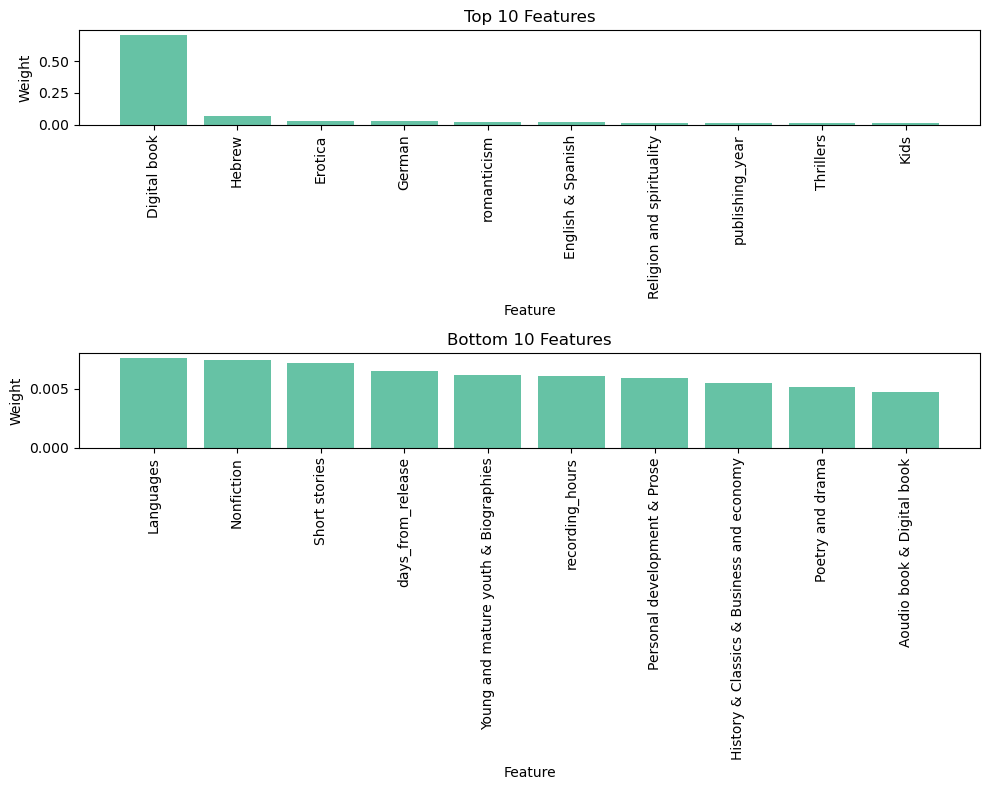

Feature Importances:
Digital book : 0.7071458
Hebrew : 0.070170775
Erotica : 0.029238762
German : 0.02471721
romanticism : 0.021539755
English & Spanish : 0.018658943
Religion and spirituality : 0.012035478
publishing_year : 0.01013426
Thrillers : 0.009673849
Kids : 0.009554574
recording_minutes : 0.009377559
Aoudio book : 0.007794219
Science fiction and fantasy & Crime : 0.0077407234
Languages : 0.007612149
Nonfiction : 0.007445948
Short stories : 0.0071853227
days_from_release : 0.0065082368
Young and mature youth & Biographies : 0.0061484557
recording_hours : 0.00611857
Personal development & Prose : 0.0058770957
History & Classics & Business and economy : 0.005485021
Poetry and drama : 0.0051111197
Aoudio book & Digital book : 0.004726201


0.6655300681959082

In [163]:
print("df_26_columns")
modle_2(df_26_columns)

df_922_columns
Accuracy: 0.8147713950762017


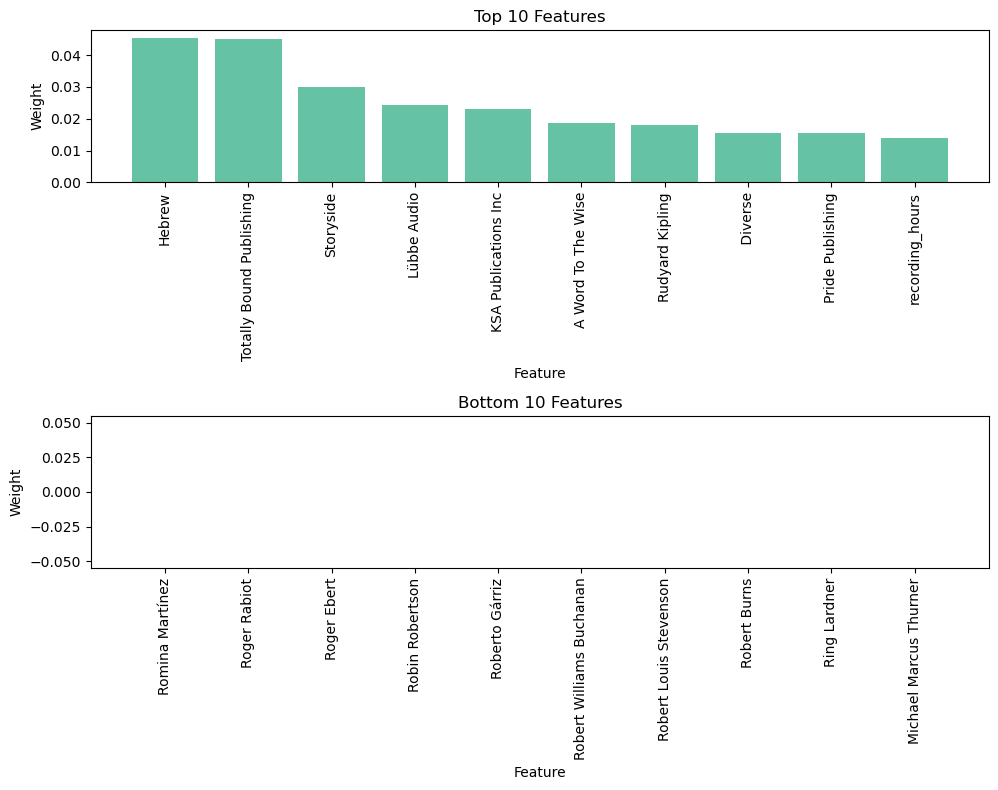

Feature Importances:
Hebrew : 0.045552142
Totally Bound Publishing : 0.04510728
Storyside : 0.029940635
Lübbe Audio : 0.02424752
KSA Publications Inc : 0.023058522
A Word To The Wise : 0.018719437
Rudyard Kipling : 0.018147465
 Diverse : 0.01549745
Pride Publishing : 0.015461052
recording_hours : 0.01392447
J-Novel Club : 0.013899507
Harlequin, una división de HarperCollins Ibérica, S.A. : 0.013882465
 Karlheinz Gabor : 0.013735299
Erotica : 0.013135838
Paul Doherty : 0.012934527
Jessa James : 0.012846228
Yukiya Murasaki : 0.0124161905
Lust : 0.011012539
Steam Books : 0.010396903
German : 0.010212472
Arthur Conan Doyle : 0.009735571
 Johannes Steck : 0.009268709
F. Scott Fitzgerald : 0.009258606
 Martin Bross : 0.0089730825
Innovative Language Learning : 0.008748509
Vanessa Vale : 0.008654707
Lope de Vega : 0.008506507
 George Guidall : 0.008479849
B.J. Hermansson : 0.00845798
Steam Books.1 : 0.008347546
Editorial Cõ : 0.008311912
Namekojirushi : 0.007969911
Canelo Adventure : 0.007918

0.8147713950762017

In [165]:
print("df_922_columns")
modle_2(df_922_columns)

df_1105_columns
Accuracy: 0.811


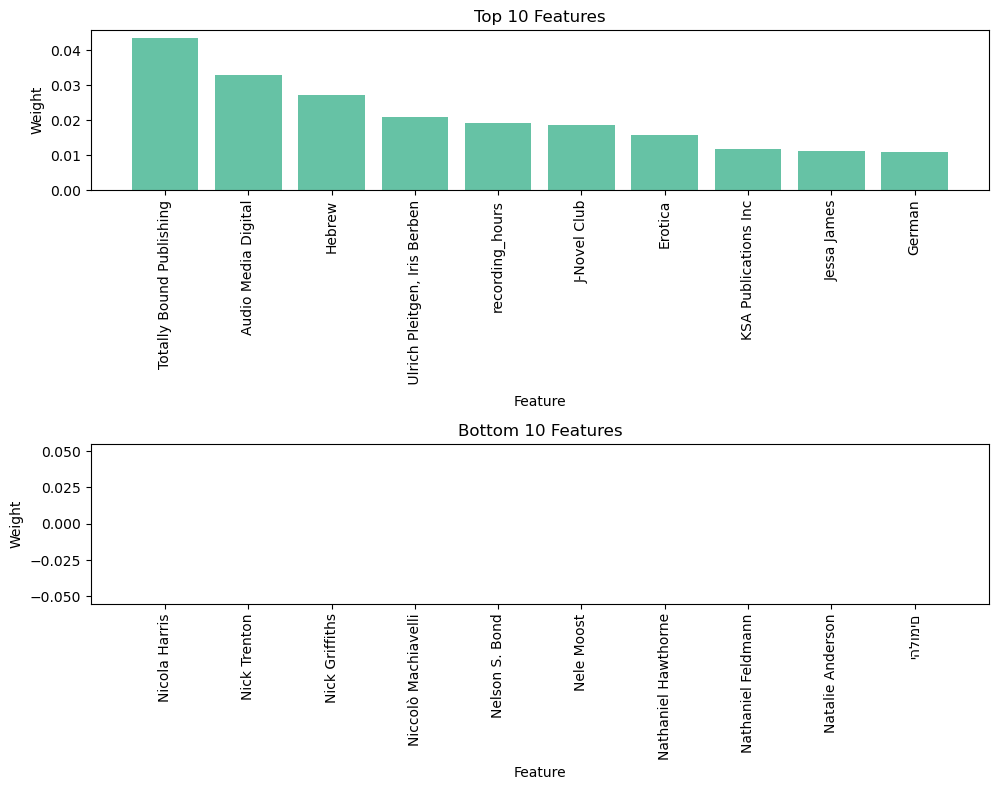

Feature Importances:
Totally Bound Publishing : 0.043553986
Audio Media Digital : 0.032980945
Hebrew : 0.02715454
 Ulrich Pleitgen, Iris Berben : 0.020800225
recording_hours : 0.019226996
J-Novel Club : 0.018707272
Erotica : 0.01577786
KSA Publications Inc : 0.011866718
Jessa James : 0.011229366
German : 0.010923165
A Word To The Wise : 0.010448093
Highscore Music : 0.010043649
 Carsten Wilhelm : 0.009819675
IRB Media : 0.009364287
Harlequin, una división de HarperCollins Ibérica, S.A. : 0.008599043
Poetry and drama : 0.008499851
Lübbe Audio : 0.008477902
 Sascha Rotermund : 0.008034811
Innovative Language Learning.1 : 0.007831422
Yukiya Murasaki : 0.007359808
 Diverse : 0.007083052
Steam Books.1 : 0.007030289
Cupido : 0.006898311
Vanessa Vale : 0.006754773
LinguaBoost : 0.006549003
Resource Publications : 0.0065021054
Read & Co. Classics : 0.006399902
Jason Dark : 0.0062636705
Steam Books : 0.0061251004
 Rolf Berg : 0.006029719
 Geoffrey Giuliano and the Icon Players : 0.0059864325
Pe

0.811

In [191]:
print("df_1105_columns")
modle_2(df_1105_columns)

### The best results were obtained for the classification model I ran on the DataFrame with 922 columns.          Compared to the regression model, this is an improvement of 101.4%

# conclusions
At the beginning of the work on the project, I expected that books in English would receive a higher rating than those in other languages. I was surprised to find that the language that affects the results the most is Hebrew. Because this is an Israeli site, it can perhaps be concluded that people prefer to read in their native language.

In addition, it can be seen that six of the top ten features are names of publishing houses, which means that publishing houses have a lot of influence on the ranking.
In the top ten features there is not a single name of an announcer and this can indicate that the announcer has no influence on the ranking. Compared to writers who do appear, but not as much as the publishers.

Furthermore, you can see in the list after the plot that there are a lot of features with a weight of 0, which means that many features have no effect on the ranking at all.